<a href="https://colab.research.google.com/github/daniellcosmo/CBM_Naval_Propulsion_Plant_ML/blob/main/CBM_Naval_Propulsion_Plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema

Predizer a deterioração de um sistema de propulsão naval: <br>
y1 [GT Compressor decay state coefficient] <br>
y2 [GT Turbine decay state coefficient]
<br>
<br>
Datase: http://archive.ics.uci.edu/ml/datasets/condition+based+maintenance+of+naval+propulsion+plants

#1. Importação dos Dados

In [1]:
%pip install optuna #optuna-3.1.0-py3-none-any.whl
%pip install bayesian-optimization #bayesian-optimization-1.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00


In [2]:
import pandas as pd #1.3.5
import numpy as np #1.22.4

import seaborn as sns #0.11.2
import matplotlib.pyplot as plt #3.5.3

from sklearn.preprocessing import MinMaxScaler #1.2.1
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, KFold

from xgboost import XGBRegressor #1.7.4
import scipy.stats as stats #1.10.1

import plotly.express as px #5.5.0
import plotly.graph_objects as go

import time
from copy import deepcopy
import pickle
import random
#import datetime
from datetime import datetime, timedelta

In [3]:
import os
import time

# Obter o fuso horário do sistema
tz = time.tzname[time.localtime().tm_isdst]

# Definir a variável de ambiente do fuso horário
os.environ['TZ'] = tz

# Atualizar o fuso horário
time.tzset()


In [4]:
import optuna #3.1.0
from optuna.samplers import TPESampler

In [5]:
from google.colab import drive
drive.mount('/content/drive')
path_objects = '/content/drive/MyDrive/ColabNotebooks/Objects/'

Mounted at /content/drive


In [6]:
# Define a semente aleatória
seed = 42
np.random.seed(seed)
random.seed(seed)

In [7]:
path = 'https://raw.githubusercontent.com/daniellcosmo/CBM_Naval_Propulsion_Plant_ML/main/dataset/'
df = pd.read_csv(path + 'data.txt', sep="   ", header=None, engine='python')

Features = [
 'lever_position',        #1
 'ship_speed',            #2
 'GT_shaft_torque',       #3
 'GT_rpm',                #4
 'GG_rpm',                #5
 'S_prplr_torque',        #6
 'P_prplr_torque',        #7
 'HP_T_exit_temp',        #8
 'GT_C_airIn_temp',       #9
 'GT_C_airOut_temp',      #10
 'HP_T_exit_pressure',    #11
 'GT_C_airIn_pressure',   #12
 'GT_C_airOut_pressure',  #13
 'GT_exhGas_pressure',    #14
 'T_inj_control',         #15
 'fuel_flow',             #16
 'GT_C_decay_coef',       #17
 'GT_T_decay_coef']       #18
df.columns = Features
df.head()

lever_position  ship_speed  GT_shaft_torque    GT_rpm    GG_rpm  \
0           1.138         3.0          289.964  1349.489  6677.380   
1           2.088         6.0         6960.180  1376.166  6828.469   
2           3.144         9.0         8379.229  1386.757  7111.811   
3           4.161        12.0        14724.395  1547.465  7792.630   
4           5.140        15.0        21636.432  1924.313  8494.777   

   S_prplr_torque  P_prplr_torque  HP_T_exit_temp  GT_C_airIn_temp  \
0           7.584           7.584         464.006            288.0   
1          28.204          28.204         635.401            288.0   
2          60.358          60.358         606.002            288.0   
3         113.774         113.774         661.471            288.0   
4         175.306         175.306         731.494            288.0   

   GT_C_airOut_temp  HP_T_exit_pressure  GT_C_airIn_pressure  \
0           550.563               1.096                0.998   
1           581.658               1.331                0.998   
2           587.587               1.389                0.998   
3           613.851               1.658                0.998   
4           645.642               2.078                0.998   

   GT_C_airOut_pressure  GT_exhGas_pressure  T_inj_control  fuel_flow  \
0                 5.947               1.019          7.137      0.082   
1                 7.282               1.019         10.655      0.287   
2                 7.574               1.020         13.086      0.259   
3                 9.007               1.022         18.109      0.358   
4                11.197               1.026         26.373      0.522   

   GT_C_decay_coef  GT_T_decay_coef  
0             0.95            0.975  
1             0.95            0.975  
2             0.95            0.975  
3             0.95            0.975  
4             0.95            0.975

In [8]:
FeaturesNames = pd.read_csv(path + "Features.txt", sep="   ", header=None, engine='python')
FeaturesNames.values.tolist()

[['1 - Lever position (lp) [ ]'],
 ['2 - Ship speed (v) [knots]'],
 ['3 - Gas Turbine shaft torque (GTT) [kN m]'],
 ['4 - Gas Turbine rate of revolutions (GTn) [rpm]'],
 ['5 - Gas Generator rate of revolutions (GGn) [rpm]'],
 ['6 - Starboard Propeller Torque (Ts) [kN]'],
 ['7 - Port Propeller Torque (Tp) [kN]'],
 ['8 - HP Turbine exit temperature (T48) [C]'],
 ['9 - GT Compressor inlet air temperature (T1) [C]'],
 ['10 - GT Compressor outlet air temperature (T2) [C]'],
 ['11 - HP Turbine exit pressure (P48) [bar]'],
 ['12 - GT Compressor inlet air pressure (P1) [bar]'],
 ['13 - GT Compressor outlet air pressure (P2) [bar]'],
 ['14 - Gas Turbine exhaust gas pressure (Pexh) [bar]'],
 ['15 - Turbine Injecton Control (TIC) [%]'],
 ['16 - Fuel flow (mf) [kg/s]'],
 ['17 - GT Compressor decay state coefficient.'],
 ['18 - GT Turbine decay state coefficient.']]

# Análise dos Dados

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lever_position        11934 non-null  float64
 1   ship_speed            11934 non-null  float64
 2   GT_shaft_torque       11934 non-null  float64
 3   GT_rpm                11934 non-null  float64
 4   GG_rpm                11934 non-null  float64
 5   S_prplr_torque        11934 non-null  float64
 6   P_prplr_torque        11934 non-null  float64
 7   HP_T_exit_temp        11934 non-null  float64
 8   GT_C_airIn_temp       11934 non-null  float64
 9   GT_C_airOut_temp      11934 non-null  float64
 10  HP_T_exit_pressure    11934 non-null  float64
 11  GT_C_airIn_pressure   11934 non-null  float64
 12  GT_C_airOut_pressure  11934 non-null  float64
 13  GT_exhGas_pressure    11934 non-null  float64
 14  T_inj_control         11934 non-null  float64
 15  fuel_flow          

In [ ]:
df.describe().transpose().drop('count', axis=1) #.to_excel('describe.xlsx', index=True)

mean           std       min         25%  \
lever_position            5.166667  2.626388e+00     1.138     3.14400   
ship_speed               15.000000  7.746291e+00     3.000     9.00000   
GT_shaft_torque       27247.498685  2.214861e+04   253.547  8375.88375   
GT_rpm                 2136.289256  7.740839e+02  1307.675  1386.75800   
GG_rpm                 8200.947312  1.091316e+03  6589.002  7058.32400   
S_prplr_torque          227.335768  2.004959e+02     5.304    60.31700   
P_prplr_torque          227.335768  2.004959e+02     5.304    60.31700   
HP_T_exit_temp          735.495446  1.736806e+02   442.364   589.87275   
GT_C_airIn_temp         288.000000  0.000000e+00   288.000   288.00000   
GT_C_airOut_temp        646.215331  7.267588e+01   540.442   578.09225   
HP_T_exit_pressure        2.352963  1.084770e+00     1.093     1.38900   
GT_C_airIn_pressure       0.998000  2.220539e-16     0.998     0.99800   
GT_C_airOut_pressure     12.297123  5.337448e+00     5.828     7.44725   
GT_exhGas_pressure        1.029474  1.039032e-02     1.019     1.02000   
T_inj_control            33.641261  2.584136e+01     0.000    13.67750   
fuel_flow                 0.662440  5.071316e-01     0.068     0.24600   
GT_C_decay_coef           0.975000  1.472022e-02     0.950     0.96200   
GT_T_decay_coef           0.987500  7.500314e-03     0.975     0.98100   

                             50%          75%        max  
lever_position            5.1400      7.14800      9.300  
ship_speed               15.0000     21.00000     27.000  
GT_shaft_torque       21630.6590  39001.42675  72784.872  
GT_rpm                 1924.3260   2678.07900   3560.741  
GG_rpm                 8482.0815   9132.60600   9797.103  
S_prplr_torque          175.2680    332.36475    645.249  
P_prplr_torque          175.2680    332.36475    645.249  
HP_T_exit_temp          706.0380    834.06625   1115.797  
GT_C_airIn_temp         288.0000    288.00000    288.000  
GT_C_airOut_temp        637.1415    693.92450    789.094  
HP_T_exit_pressure        2.0830      2.98100      4.560  
GT_C_airIn_pressure       0.9980      0.99800      0.998  
GT_C_airOut_pressure     11.0920     15.65800     23.140  
GT_exhGas_pressure        1.0260      1.03600      1.052  
T_inj_control            25.2765     44.55250     92.556  
fuel_flow                 0.4960      0.88200      1.832  
GT_C_decay_coef           0.9750      0.98800      1.000  
GT_T_decay_coef           0.9875      0.99400      1.000

##BoxPlot Normalizado

In [ ]:
x = df.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_df = pd.DataFrame(x_scaled)
normalized_df.columns = Features

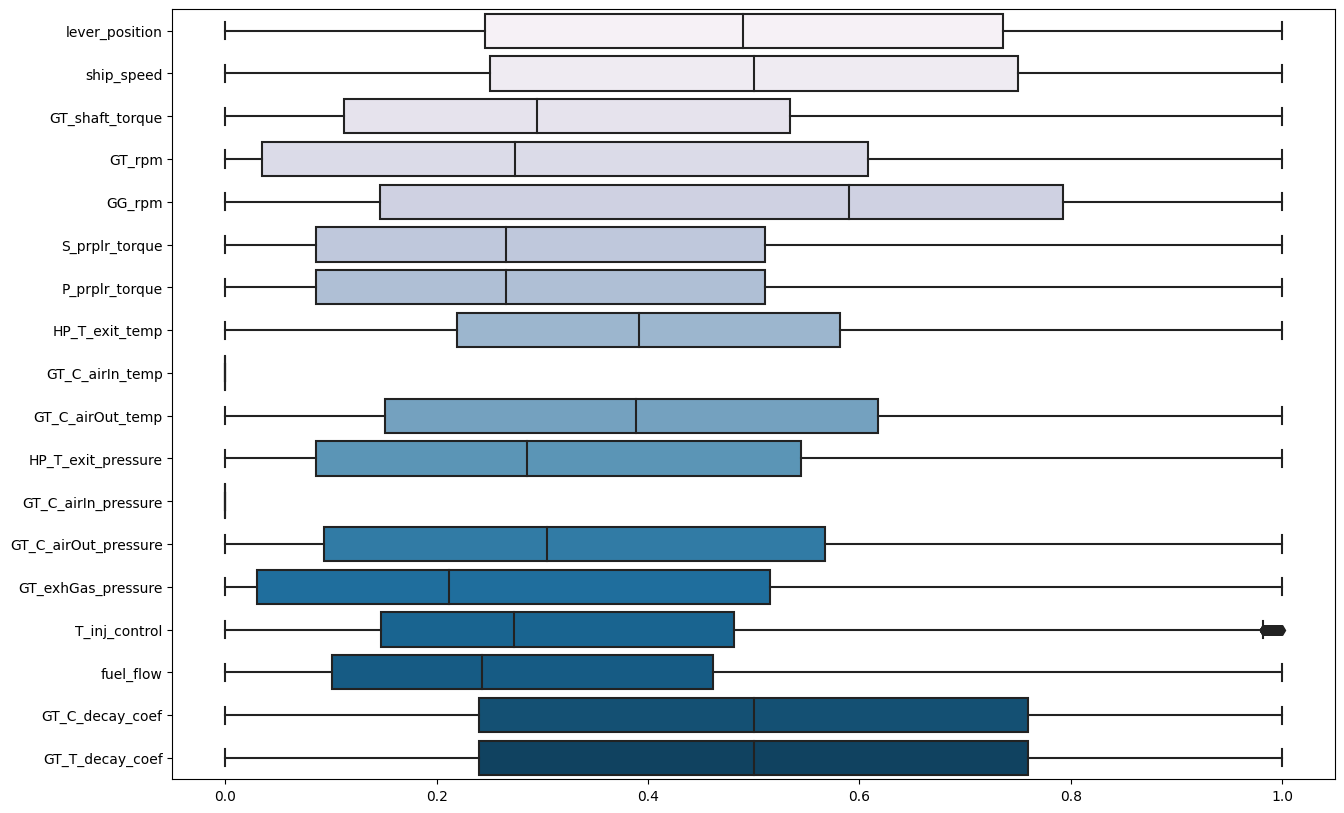

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
_= sns.boxplot(data=normalized_df, dodge=False, orient="h")

Como é possível visualizar, as features:
*   GT_C__airIn_pressure; e
*   GT_C__airIn_temp

possuem std igual a zero, comportando-se como constante sem fazer um impacto no resultado final.
<br>
Dado isso, podemos removê-las do modelo.

In [ ]:
remove = ['GT_C_airIn_temp',
          'GT_C_airIn_pressure',
          'S_prplr_torque']

for f in remove:
    try:
        df=df.drop(f, axis=1)
    except:
        pass
    print('Removida feature ', f)

Removida feature  GT_C_airIn_temp
Removida feature  GT_C_airIn_pressure
Removida feature  S_prplr_torque


##Gráfico dos n primeiros valores das variáveis

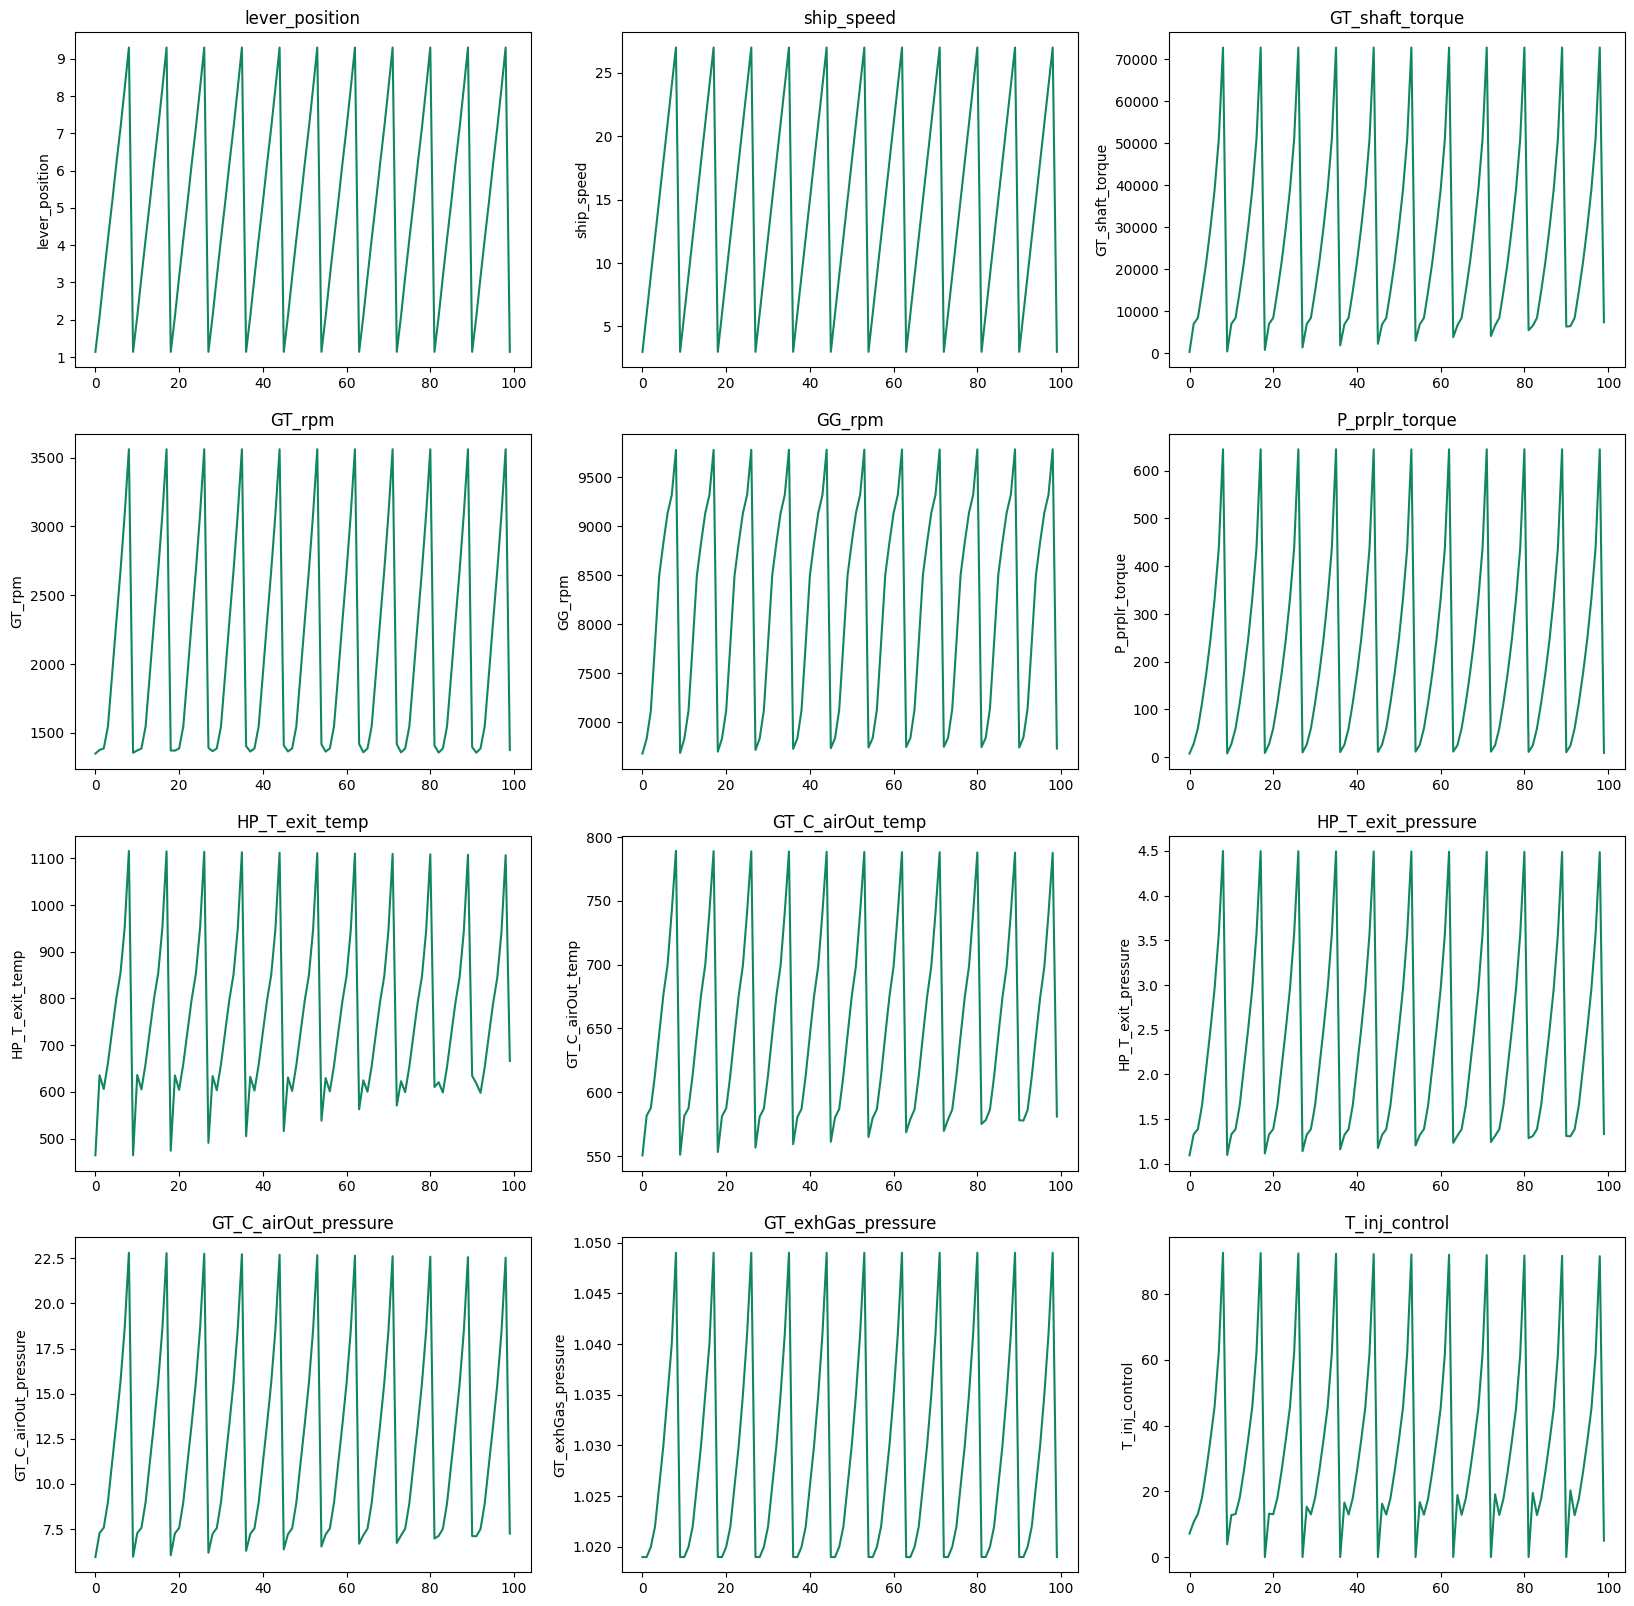

In [ ]:
n = 100

fig, axes = plt.subplots(nrows = 4, ncols = 3)    # axes is 2d array (4x4)
axes = axes.flatten()         # Convert axes to 1d array of length nrows x rcols
fig.set_size_inches(20, 20)

for ax, col in zip(axes, df.columns):
  sns.lineplot(x = [*range(n)], y = df[col][:n], ax = ax, color=sns.xkcd_rgb['dark sea green']).set(xlabel=None)
  ax.set_title(col)

##Histograma de Frequências e Distribuição Normal

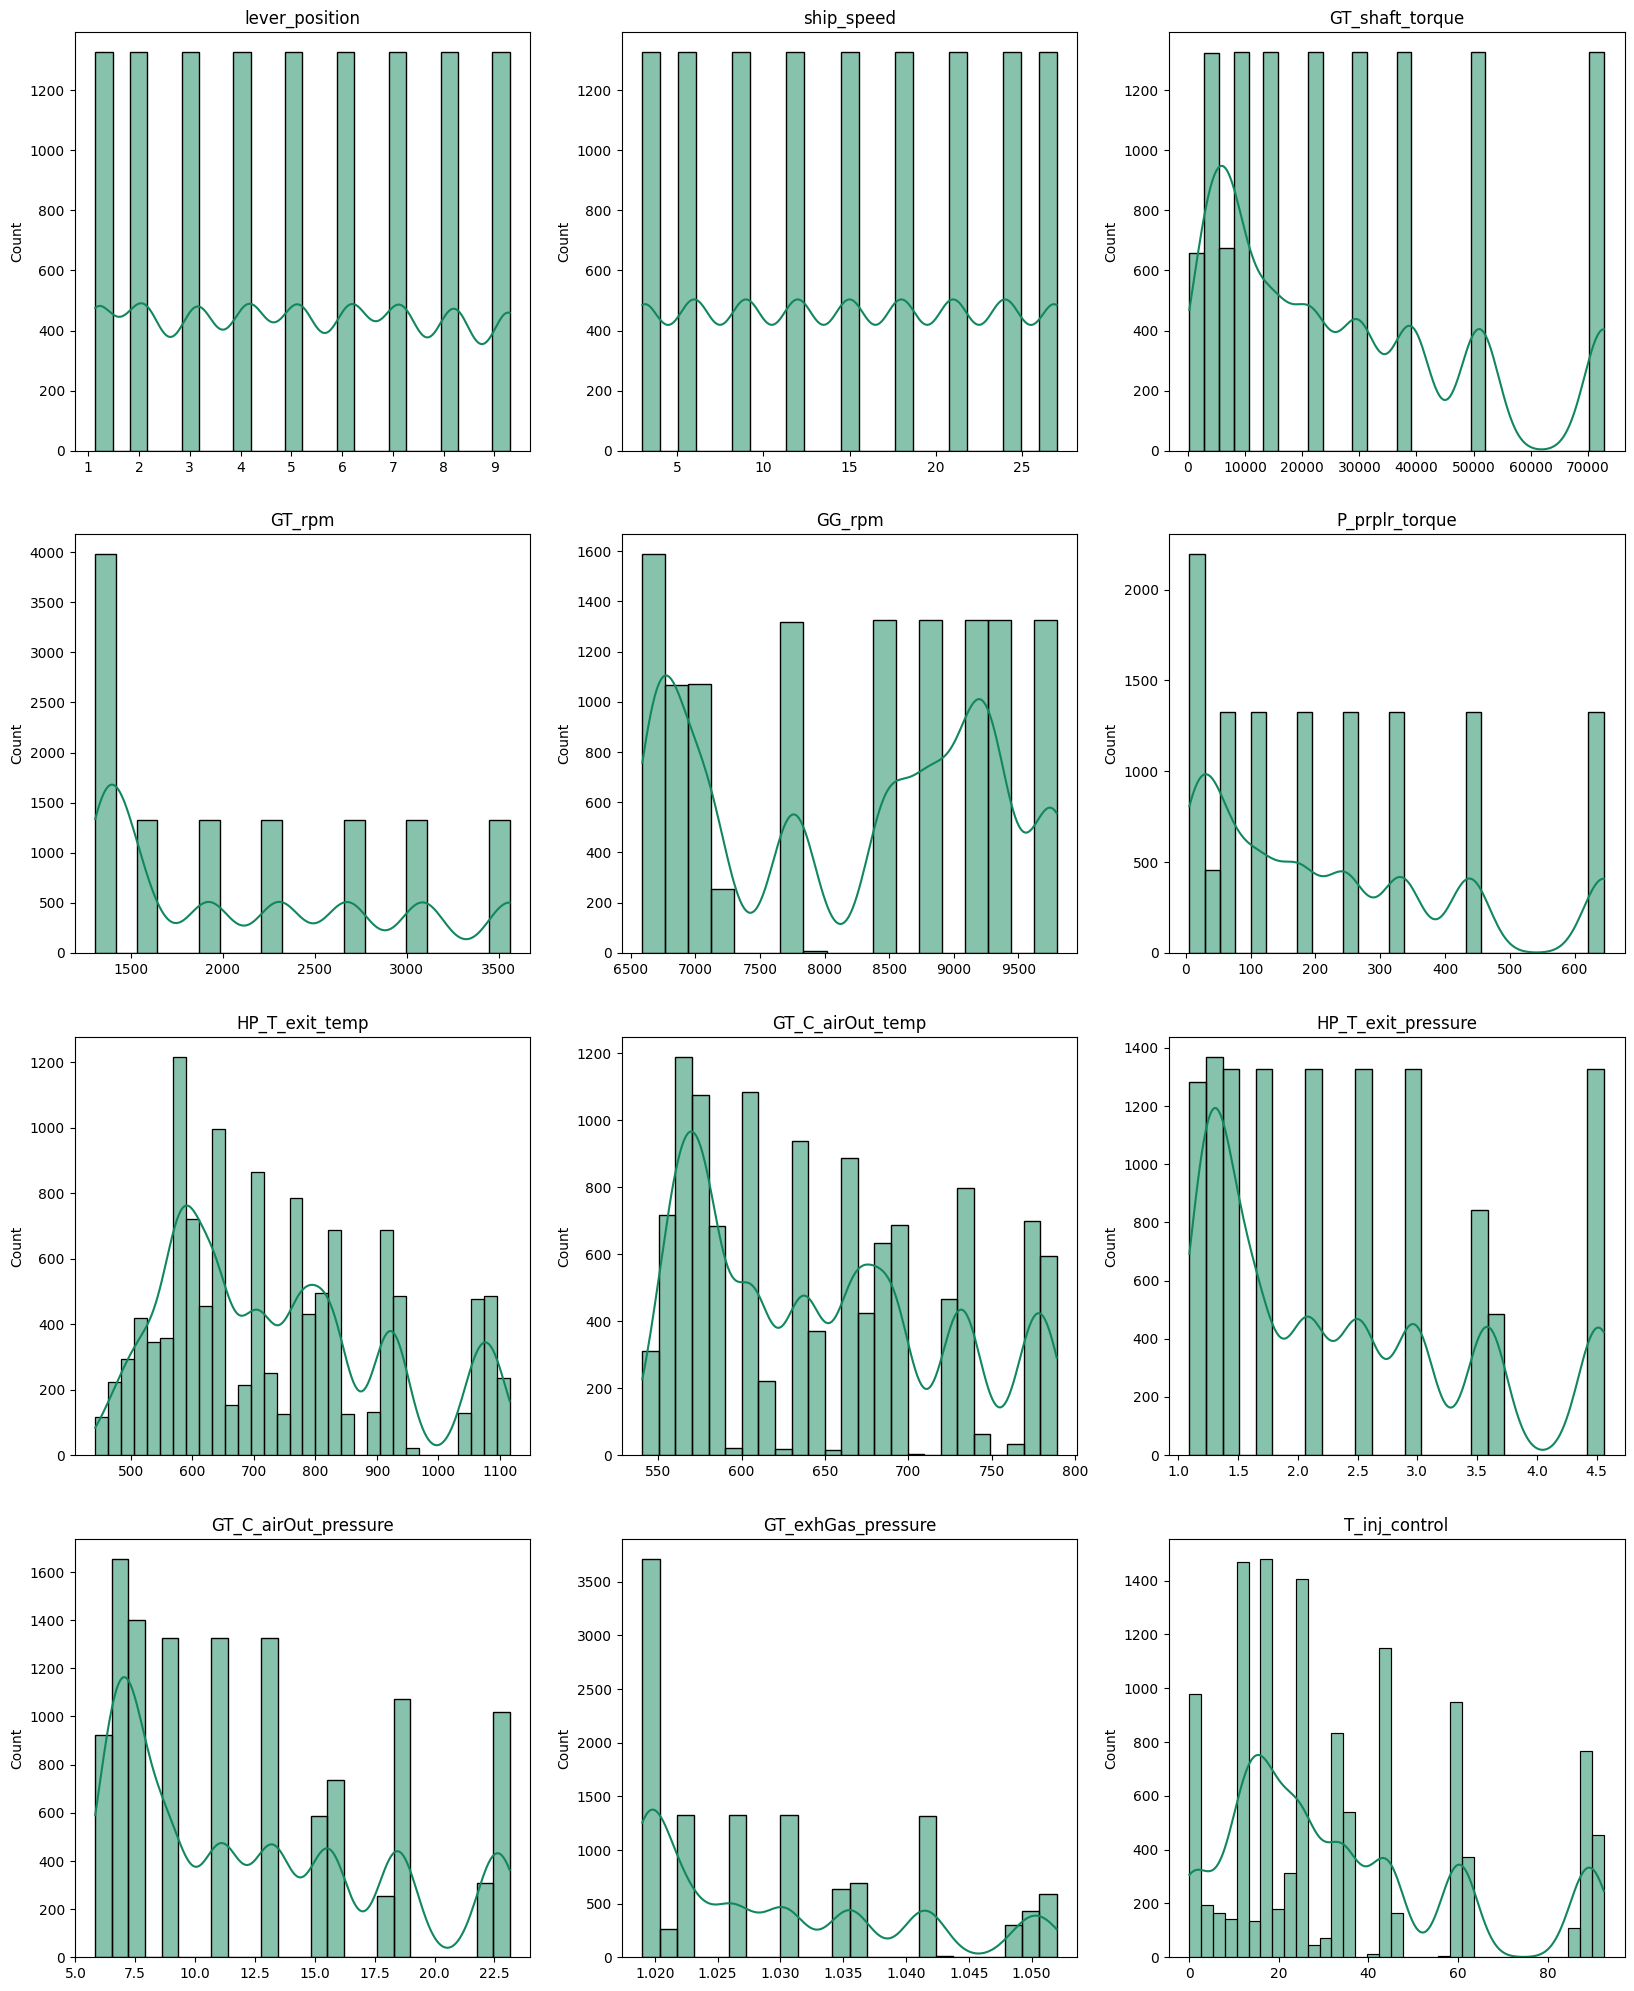

In [ ]:
# sns.displot(df['lever_position'], kde=True)
# https://www.biomooc.com/color/seabornColors.html

fig, axes = plt.subplots(nrows = 4, ncols = 3)    # axes is 2d array (4x4)
axes = axes.flatten()         # Convert axes to 1d array of length nrows x rcols
fig.set_size_inches(20, 25)

for ax, col in zip(axes, df.columns):
  sns.histplot(df[col], ax = ax, kde=True, color=sns.xkcd_rgb['dark sea green']).set(xlabel=None) # , label="Compact"
  ax.set_title(col)



##Teste de Normalidade de Kolmogorov-Smirnov



In [ ]:
testeNormal = pd.DataFrame(index=[ "Segue Distribuição Normal?"])

for col in df.columns:
    stat,p= stats.normaltest(df[col])
    if p<=0.05:
        testeNormal[col] = 'Não'
    else:
        testeNormal[col] = 'Sim'

testeNormal = testeNormal.T
testeNormal

Segue Distribuição Normal?
lever_position                              Não
ship_speed                                  Não
GT_shaft_torque                             Não
GT_rpm                                      Não
GG_rpm                                      Não
P_prplr_torque                              Não
HP_T_exit_temp                              Não
GT_C_airOut_temp                            Não
HP_T_exit_pressure                          Não
GT_C_airOut_pressure                        Não
GT_exhGas_pressure                          Não
T_inj_control                               Não
fuel_flow                                   Não
GT_C_decay_coef                             Não
GT_T_decay_coef                             Não

Ou seja, o valor-p foi menor do que nosso nível de significância, logo, a probabilidade de obtermos dados como estes é muito pequena. Assim, podemos concluir que os valores não seguem distribuição normal.

## Heatmap

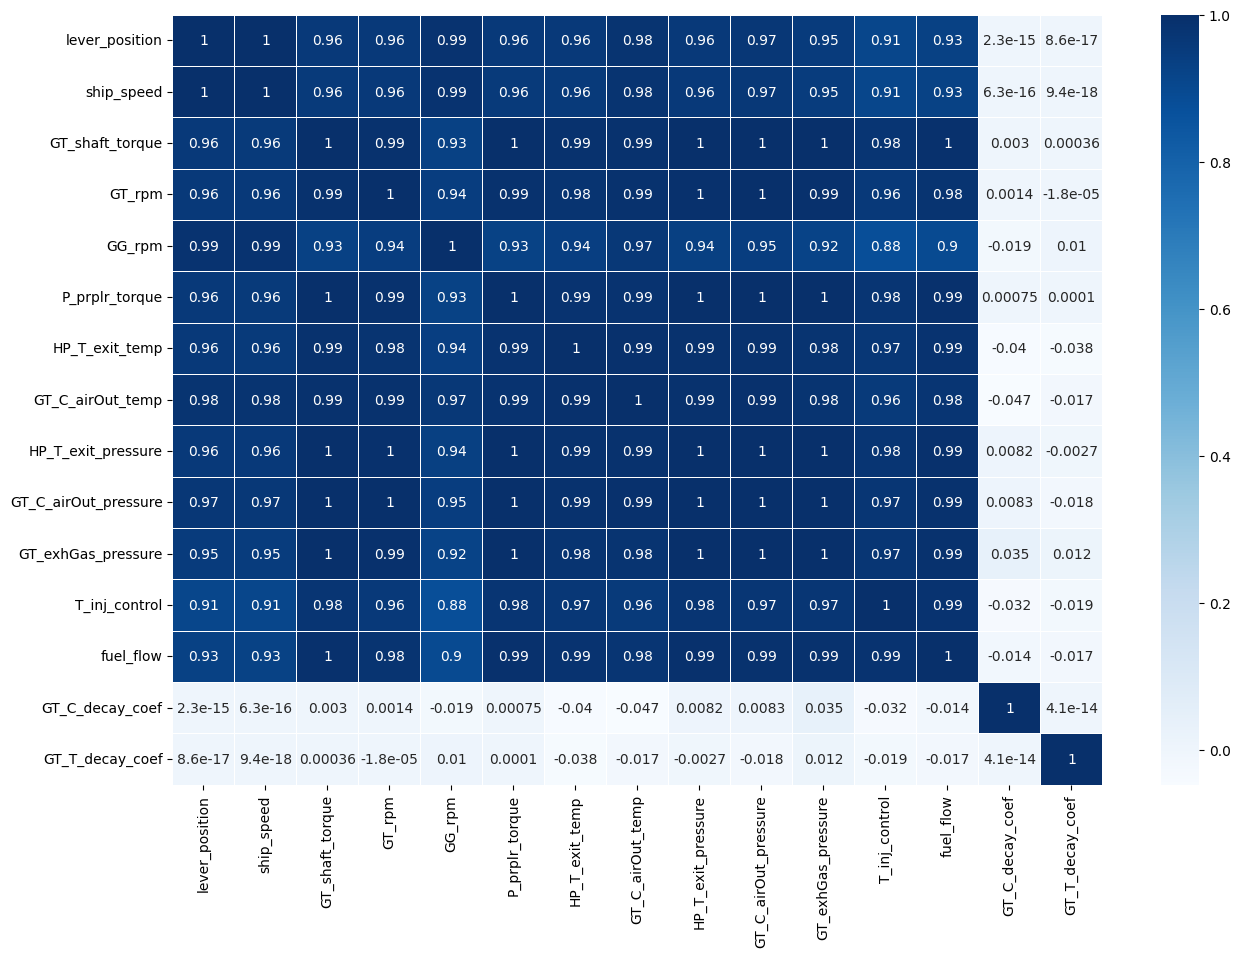

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
_= sns.heatmap(df.corr(), cmap = 'Blues', linewidth=0.5, annot=True)

Como as features tem uma alta correlação entre elas e uma baixa entre as respostas podemos assumir que as features e as respostas possuem uma não-linearidade entre si.

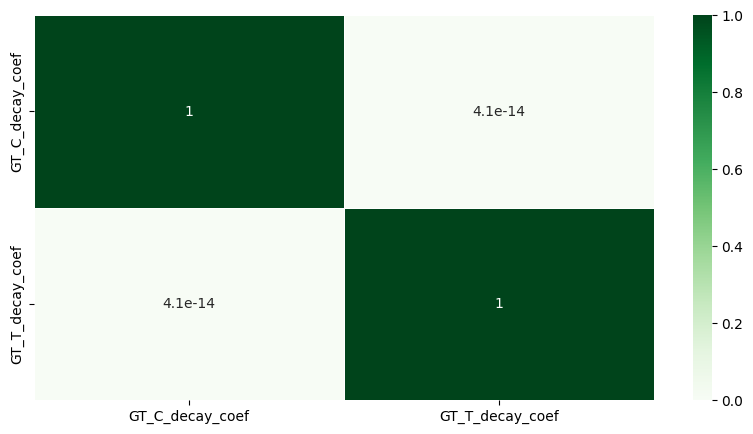

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
_= sns.heatmap(df.iloc[: , -2:].corr(), cmap = 'Blues', linewidth=0.5, annot=True)

Como as respostas também possuem uma baixa correlação entre si, iremos considerá-las independentes, com isso, usá-las em treinos diferentes

# 3. Pré-Processamento

## Limpeza dos Dados

In [ ]:
remove = ['GT_C_airIn_temp',
          'GT_C_airIn_pressure',
          'S_prplr_torque']

for f in remove:
    try:
        df=df.drop(f, axis=1)
    except:
        pass
    print('Removida feature ', f)

Removida feature  GT_C_airIn_temp
Removida feature  GT_C_airIn_pressure
Removida feature  S_prplr_torque


## Divisão em Features e Targets

In [ ]:
X_raw = df.iloc[: , :-2]
Y = df.iloc[:, -2:]
y1 = df['GT_C_decay_coef']
y2 = df['GT_T_decay_coef']

## Treino e Teste

In [ ]:
x_train_raw,x_test_raw,y_train,y_test = train_test_split(X_raw,Y) # , shuffle=True

# x1_train_raw,x1_test_raw,y1_train,y1_test = train_test_split(X_raw,y1)
# x2_train_raw,x2_test_raw,y2_train,y2_test = train_test_split(X_raw,y2)

y1_train = y_train['GT_C_decay_coef']
y1_test = y_test['GT_C_decay_coef']

y2_train = y_train['GT_C_decay_coef']
y2_test = y_test['GT_C_decay_coef']

##Normalização

In [ ]:
sc = StandardScaler()

# Normalizando utilizando todo o X
# X = pd.DataFrame(sc.fit_transform(X_raw), columns=X_raw.columns.values.tolist())

# Normalizando utilizando apenas o x_train para evitar contaminação
X = pd.DataFrame(sc.fit_transform(x_train_raw), columns=X_raw.columns.values.tolist())

x_train = sc.transform(x_train_raw)
x_test = sc.transform(x_test_raw)

# x2_train = sc.transform(x2_train_raw)
# x2_test = sc.transform(x2_test_raw)

In [ ]:
x_train = pd.DataFrame(x_train, columns= X.columns)
x_test = pd.DataFrame(x_test, columns= X.columns)

In [ ]:
def check_zero_values(df):
    zero_values = (df == 0).sum()
    return zero_values.any()

check_zero_values(X)

False

#4. Funções para os Modelos

In [ ]:
models = {'KNeighborsRegressor': KNeighborsRegressor(),
          'BaggingRegressor': BaggingRegressor(),
          'SVR': SVR(kernel='rbf', epsilon = 10E-4)
          }

In [ ]:
def train_models(x_train, y_train, x_test, y_test, models):
  _models = deepcopy(models)
  y_info = pd.DataFrame(columns=['Modelo','Tempo [Treino]'],
                       index = _models.keys())

  for i, model in enumerate(_models.keys()):
    start_time = time.perf_counter()
    y_info.loc[y_info.index[i], 'Modelo'] = _models[model].fit(x_train, y_train)
    y_info.loc[y_info.index[i], 'Tempo [Treino]'] = time.perf_counter() - start_time

  y_info.columns.name = 'Modelo'

  return y_info

In [ ]:
def metric_models(x_train, y_train, x_test, y_test, models_):
    models = {}
    if isinstance(models_, pd.DataFrame):
        for idx, row in models_.iterrows():
            models[idx] = row[0]
    elif isinstance(models_, dict):
        models = models_
    else:
        raise ValueError("The input data must be a DataFrame or a dictionary")

    y_info = pd.DataFrame(columns=['Modelo', 'MAPE', 'MAE', 'MSE', 'RMSE', 'R² [Treino]', 'R² [Teste]', 'Tempo [Treino]', 'Tempo [Teste]', 'Y Predicted Test'],
                          index=models.keys())
    y_info.columns.name = 'Modelo'
    for i, model in enumerate(models.keys()):
        start_time = time.perf_counter()
        y_pred = models[model].predict(x_test)
        y_info.at[y_info.index[i], 'Tempo [Teste]'] = time.perf_counter() - start_time
        y_info.at[y_info.index[i], 'Modelo'] = models[model]
        y_info.at[y_info.index[i], 'R² [Treino]'] = models[model].score(x_train, y_train)
        y_info.at[y_info.index[i], 'R² [Teste]'] = models[model].score(x_test, y_test)
        y_info.at[y_info.index[i], 'MAE'] = mean_absolute_error(y_test, y_pred)
        y_info.at[y_info.index[i], 'MAPE'] = metrics.mean_absolute_percentage_error(y_test, y_pred)
        y_info.at[y_info.index[i], 'MSE'] = mean_squared_error(y_test, y_pred)
        y_info.at[y_info.index[i], 'RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
        y_info.at[y_info.index[i], 'Y Predicted Test'] = y_pred


    if isinstance(models_, pd.DataFrame):
      y_info['Tempo [Treino]'] = models_['Tempo [Treino]']

    return y_info


In [ ]:
def calculate_mape(y_true, y_pred): # MAPE em %
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def mean_absolute_percentage_error_score(y_true, y_pred): # MAPE em %
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mape * 100

In [ ]:
def cross_validate_models(X, y, models, n_splits=5):
    _models = deepcopy(models)
    y_info = pd.DataFrame(index=_models.keys())

    # Define as métricas de avaliação desejadas
    scoring = {
        'MAPE': make_scorer(mean_absolute_percentage_error),
        'MAE': make_scorer(mean_absolute_error),
        'MSE': make_scorer(mean_squared_error),
        'RMSE': make_scorer(mean_squared_error, squared=False),
        'R² [Teste]': make_scorer(r2_score),
              }
    # Cross Validation e Resultados
    cv = KFold(n_splits=n_splits, shuffle=True) # , random_state=seed
    # cv = TimeSeriesSplit(n_splits=n_splits)

    for i, (model_name, model) in enumerate(_models.items()):
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

        for metric in scoring:
            y_info.at[model_name, metric] = cv_results[f'test_{metric}'].mean()

        y_info.at[model_name, 'Tempo [Treino]'] = np.mean(cv_results['fit_time'])
        y_info.at[model_name, 'Tempo [Teste]'] = np.mean(cv_results['score_time'])

    columns = y_info.columns.tolist()
    columns.remove('R² [Teste]')
    columns.append('R² [Teste]')
    y_info = y_info.reindex(columns=columns)
    y_info.columns.name = 'Modelo'

    return y_info

In [ ]:
def cross_validation(X, y, model, n_splits=5):

    scoring = {'MAPE': make_scorer(mean_absolute_percentage_error)}


    # Cross Validation e Resultados
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    mean_results = cv_results['test_MAPE'].mean()
    return mean_results

In [ ]:
def p2c(df):
  return df.applymap(lambda x: str(x).replace('.', ','))

# Modelos sem Redução de Dimensionalidade [Não Usado]

### Treinamento Convencional

#### Modelos para y1

In [ ]:
y1_models = train_models(x_train, y2_train, x_test, y2_test, models)

In [ ]:
metric_models(x_train, y1_train, x_test, y1_test, y1_models).drop(['Modelo'], axis=1).drop(['Y Predicted Test'], axis=1)

Modelo                   MAPE       MAE       MSE      RMSE R² [Treino]  \
KNeighborsRegressor  0.000792  0.000771  0.000003  0.001593    0.992396   
BaggingRegressor     0.000631  0.000615  0.000001  0.001075    0.998677   
SVR                  0.000633  0.000617  0.000001  0.000709    0.997625   

Modelo              R² [Teste] Tempo [Treino] Tempo [Teste]  
KNeighborsRegressor   0.988164       0.019221      0.029656  
BaggingRegressor      0.994604       0.566601      0.010541  
SVR                   0.997657       0.229833      0.026719

In [ ]:
metric_models(x_train, y1_train, x_test, y1_test, y1_models).drop(['Modelo'], axis=1).drop(['Y Predicted Test'], axis=1)

Modelo                   MAPE       MAE       MSE      RMSE R² [Treino]  \
KNeighborsRegressor  0.079174  0.000771  0.000003  0.001593    0.992396   
BaggingRegressor     0.063057  0.000615  0.000001  0.001075    0.998677   
SVR                  0.063268  0.000617  0.000001  0.000709    0.997625   

Modelo              R² [Teste] Tempo [Treino] Tempo [Teste]  
KNeighborsRegressor   0.988164       0.019221      0.036743  
BaggingRegressor      0.994604       0.566601      0.010869  
SVR                   0.997657       0.229833      0.047173

#### Modelos para y2

In [ ]:
y2_models = train_models(x_train, y2_train, x_test, y2_test, models)

In [ ]:
metric_models(x_train, y2_train, x_test, y2_test, y2_models).drop(['Modelo'], axis=1).drop(['Y Predicted Test'], axis=1)

Modelo                   MAPE       MAE       MSE      RMSE R² [Treino]  \
KNeighborsRegressor  0.079174  0.000771  0.000003  0.001593    0.992396   
BaggingRegressor     0.063843  0.000622  0.000001  0.001079    0.998631   
SVR                  0.063268  0.000617  0.000001  0.000709    0.997625   

Modelo              R² [Teste] Tempo [Treino] Tempo [Teste]  
KNeighborsRegressor   0.988164        0.02925      0.028734  
BaggingRegressor      0.994572       0.816859      0.009167  
SVR                   0.997657       0.393792      0.048953

### Treinamento com Validação Cruzada

#### Modelos para y1

In [ ]:
cross_validate_models(x_train, y1_train, models)

Modelo               MAPE [%]       MAE           MSE      RMSE  \
KNeighborsRegressor  0.095345  0.000930  3.802798e-06  0.001949   
BaggingRegressor     0.072795  0.000710  1.820164e-06  0.001346   
SVR                  0.060829  0.000593  4.773240e-07  0.000691   

Modelo               Tempo [Treino]  Tempo [Teste]  R² [Teste]  
KNeighborsRegressor        0.013671       0.020935    0.982491  
BaggingRegressor           0.730305       0.013116    0.991630  
SVR                        0.766148       0.097347    0.997805

#### Modelos para y2

In [ ]:
cross_validate_models(x_train, y2_train, models)

Modelo               MAPE [%]       MAE           MSE      RMSE  \
KNeighborsRegressor  0.094968  0.000926  3.689895e-06  0.001920   
BaggingRegressor     0.073666  0.000719  1.951698e-06  0.001393   
SVR                  0.061604  0.000601  4.832561e-07  0.000695   

Modelo               Tempo [Treino]  Tempo [Teste]  R² [Teste]  
KNeighborsRegressor        0.013835       0.018862    0.982986  
BaggingRegressor           0.900745       0.013987    0.991033  
SVR                        0.394401       0.042043    0.997777

#5. VIF

In [ ]:
def calculate_vif(df):
  vif, tolerance = {}, {}
  features = df.columns
  # As features que queremos examinar
  for feature in features:

    # Extrair todos os outros recursos que iremos regress
    #
    X_ = [f for f in features if f != feature]
    X_, y_ = df[X_], df[feature]

    # Extrair o r^2 do fit
    r2 = LinearRegression().fit(X_, y_).score(X_, y_)

    # Calcular a tolerância
    tolerance[feature] = 1 - r2

    # Calcular o VIF
    vif[feature] = 1/(tolerance[feature])

    # Retornar o VIF do DataFrame
  return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance}).abs().sort_values(ascending=True, by=['VIF'])

In [ ]:
def VIF_features(X, threshold):
  calculated_vif = calculate_vif(X)
  return calculated_vif[calculated_vif['VIF'] < threshold].index.to_list()

In [ ]:
y1_calculated_vif = calculate_vif(X)
y1_calculated_vif

VIF  Tolerance
T_inj_control            64.292288   0.015554
GG_rpm                  273.744565   0.003653
GT_exhGas_pressure     1282.589318   0.000780
GT_C_airOut_temp       1536.702042   0.000651
GT_rpm                 1596.822868   0.000626
HP_T_exit_temp         3542.792747   0.000282
GT_C_airOut_pressure   6123.775201   0.000163
fuel_flow             11277.570009   0.000089
P_prplr_torque        12130.617950   0.000082
GT_shaft_torque       19016.767562   0.000053
HP_T_exit_pressure    31535.833890   0.000032
ship_speed            35793.613164   0.000028
lever_position        42201.037132   0.000024

#Y1

## Redução de Dimensionalidade

### Modelos usando Redução de Dimensionalidade por VIF

#### Treinamento com Validação Cruzada e VIF

In [ ]:
print(list(x_train.columns),'\n')
cv_metrics = cross_validate_models(x_train, y1_train, models)

['lever_position', 'ship_speed', 'GT_shaft_torque', 'GT_rpm', 'GG_rpm', 'P_prplr_torque', 'HP_T_exit_temp', 'GT_C_airOut_temp', 'HP_T_exit_pressure', 'GT_C_airOut_pressure', 'GT_exhGas_pressure', 'T_inj_control', 'fuel_flow'] 



In [ ]:
p2c(cv_metrics)

Modelo                                MAPE                    MAE  \
KNeighborsRegressor  0,0009395434732668292  0,0009164022346368806   
BaggingRegressor     0,0007399114217849603  0,0007217877094972116   
SVR                  0,0006194945592044742  0,0006037864857124709   

Modelo                                  MSE                   RMSE  \
KNeighborsRegressor  3,5167061452514005e-06  0,0018734175512359597   
BaggingRegressor      1,835691620111729e-06  0,0013509852030257406   
SVR                    4,93437963140971e-07  0,0007019640268921481   

Modelo                     Tempo [Treino]         Tempo [Teste]  \
KNeighborsRegressor  0,013737058639526368  0,019112920761108397   
BaggingRegressor       0,6353212356567383  0,009251546859741212   
SVR                     0,272645092010498  0,028538894653320313   

Modelo                       R² [Teste]  
KNeighborsRegressor  0,9838366216512018  
BaggingRegressor     0,9915611464471258  
SVR                   0,997729147171286

In [ ]:
VIF = 2000
print(VIF_features(X, VIF),'\n')
cv_metrics_2000 = cross_validate_models(x_train.loc[:,VIF_features(X, VIF)], y1_train, models)

['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure', 'GT_C_airOut_temp', 'GT_rpm'] 



In [ ]:
p2c(cv_metrics_2000)

Modelo                                MAPE                    MAE  \
KNeighborsRegressor  0,0009486484404172383   0,000925698324022356   
BaggingRegressor     0,0007533142840716071  0,0007350391061452569   
SVR                  0,0023662264012533326  0,0023116726774177468   

Modelo                                  MSE                   RMSE  \
KNeighborsRegressor   5,233086033519557e-06  0,0022827666970176887   
BaggingRegressor     2,1821608938547536e-06  0,0014758396005370828   
SVR                  2,1082961517929877e-05   0,004587499441351904   

Modelo                     Tempo [Treino]         Tempo [Teste]  \
KNeighborsRegressor  0,014227676391601562   0,01982855796813965   
BaggingRegressor      0,29377384185791017  0,009676074981689453   
SVR                    1,9903672218322754    0,2566436767578125   

Modelo                       R² [Teste]  
KNeighborsRegressor  0,9758729616723698  
BaggingRegressor     0,9899559040985055  
SVR                  0,9028016753232692

In [ ]:
VIF = 1500
print(VIF_features(X, VIF),'\n')
cv_metrics_1500 = cross_validate_models(x_train.loc[:,VIF_features(X, VIF)], y1_train, models)

['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure'] 



In [ ]:
p2c(cv_metrics_1500)

Modelo                                MAPE                    MAE  \
KNeighborsRegressor  0,0015188067069993704  0,0014804022346368792   
BaggingRegressor     0,0013111069236717925  0,0012774972067039162   
SVR                    0,00575840943670067   0,005616317712111092   

Modelo                                  MSE                   RMSE  \
KNeighborsRegressor  1,0884388826815662e-05  0,0032866990821226864   
BaggingRegressor      8,377796648044702e-06   0,002883505906114072   
SVR                   5,704594264369129e-05   0,007552173618271324   

Modelo                     Tempo [Treino]         Tempo [Teste]  \
KNeighborsRegressor  0,011094617843627929  0,018522262573242188   
BaggingRegressor       0,1800368309020996  0,008817100524902343   
SVR                     7,809615755081177    1,3511802196502685   

Modelo                       R² [Teste]  
KNeighborsRegressor  0,9499701666484963  
BaggingRegressor      0,961367944604046  
SVR                  0,7374308374457249

In [ ]:
VIF = 1000
print(VIF_features(X, VIF),'\n')
cv_metrics_1000 = cross_validate_models(x_train.loc[:,VIF_features(X, VIF)], y1_train, models)

['T_inj_control', 'GG_rpm'] 



In [ ]:
p2c(cv_metrics_1000)

Modelo                                MAPE                    MAE  \
KNeighborsRegressor  0,0018394223270875084  0,0017944357541899519   
BaggingRegressor      0,001734122416336507  0,0016917039106145299   
SVR                   0,011156392051762313   0,010878104792512597   

Modelo                                  MSE                  RMSE  \
KNeighborsRegressor  1,7930882681564294e-05  0,004224905880223329   
BaggingRegressor        1,7516511452514e-05  0,004183819292612177   
SVR                  0,00018383250102992896  0,013558016631846432   

Modelo                    Tempo [Treino]         Tempo [Teste]  \
KNeighborsRegressor  0,01081852912902832  0,021858024597167968   
BaggingRegressor       0,332891845703125  0,014888191223144531   
SVR                   4,0395646572113035    1,1997915744781493   

Modelo                        R² [Teste]  
KNeighborsRegressor   0,9174262548087336  
BaggingRegressor      0,9193607506377874  
SVR                  0,15420998733738597

In [ ]:
cv_metrics_1000['VIF'] = 1000
cv_metrics_1500['VIF'] = 1500
cv_metrics_2000['VIF'] = 2000
y1_cv_metrics = pd.concat([cv_metrics_1000, cv_metrics_1500, cv_metrics_2000])
p2c(y1_cv_metrics)

Modelo                                MAPE                    MAE  \
KNeighborsRegressor  0,0018394223270875084  0,0017944357541899519   
BaggingRegressor      0,001734122416336507  0,0016917039106145299   
SVR                   0,011156392051762313   0,010878104792512597   
KNeighborsRegressor  0,0015188067069993704  0,0014804022346368792   
BaggingRegressor     0,0013111069236717925  0,0012774972067039162   
SVR                    0,00575840943670067   0,005616317712111092   
KNeighborsRegressor  0,0009486484404172383   0,000925698324022356   
BaggingRegressor     0,0007533142840716071  0,0007350391061452569   
SVR                  0,0023662264012533326  0,0023116726774177468   

Modelo                                  MSE                   RMSE  \
KNeighborsRegressor  1,7930882681564294e-05   0,004224905880223329   
BaggingRegressor        1,7516511452514e-05   0,004183819292612177   
SVR                  0,00018383250102992896   0,013558016631846432   
KNeighborsRegressor  1,0884388826815662e-05  0,0032866990821226864   
BaggingRegressor      8,377796648044702e-06   0,002883505906114072   
SVR                   5,704594264369129e-05   0,007552173618271324   
KNeighborsRegressor   5,233086033519557e-06  0,0022827666970176887   
BaggingRegressor     2,1821608938547536e-06  0,0014758396005370828   
SVR                  2,1082961517929877e-05   0,004587499441351904   

Modelo                     Tempo [Treino]         Tempo [Teste]  \
KNeighborsRegressor   0,01081852912902832  0,021858024597167968   
BaggingRegressor        0,332891845703125  0,014888191223144531   
SVR                    4,0395646572113035    1,1997915744781493   
KNeighborsRegressor  0,011094617843627929  0,018522262573242188   
BaggingRegressor       0,1800368309020996  0,008817100524902343   
SVR                     7,809615755081177    1,3511802196502685   
KNeighborsRegressor  0,014227676391601562   0,01982855796813965   
BaggingRegressor      0,29377384185791017  0,009676074981689453   
SVR                    1,9903672218322754    0,2566436767578125   

Modelo                        R² [Teste]   VIF  
KNeighborsRegressor   0,9174262548087336  1000  
BaggingRegressor      0,9193607506377874  1000  
SVR                  0,15420998733738597  1000  
KNeighborsRegressor   0,9499701666484963  1500  
BaggingRegressor       0,961367944604046  1500  
SVR                   0,7374308374457249  1500  
KNeighborsRegressor   0,9758729616723698  2000  
BaggingRegressor      0,9899559040985055  2000  
SVR                   0,9028016753232692  2000

In [ ]:
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
path_model = path_objects + 'y1_cv_metrics' + '_' + now + '.pkl'

with open(path_model, 'wb') as f:
    pickle.dump(y1_cv_metrics, f)

print(now)
print(path_model)

2023-06-09-23h04
/content/drive/MyDrive/ColabNotebooks/Objects/y1_cv_metrics_2023-06-09-23h04.pkl


#### Treinamento Tradicional com VIF

#####Modelos usando features com VIF menor que 1000

In [ ]:
VIF = 1000
features = y1_calculated_vif[y1_calculated_vif['VIF'] < VIF].index.to_list()
print('Features ( VIF < ', VIF, '):\n', features)

Features ( VIF <  1000 ):
 ['T_inj_control', 'GG_rpm']


In [ ]:
# Treinando o Modelo com as Features Selecionadas
x_train_reduced = x_train.loc[:, features]
x_test_reduced = x_test.loc[:, features]
y1_models_1000 = train_models(x_train_reduced.values, y1_train, x_test_reduced.values, y1_test, models)

# Métricas
y1_models_1000 = metric_models(x_train_reduced.values, y1_train, x_test_reduced.values, y1_test, y1_models_1000)

In [ ]:
y1_models_1000.drop(['Modelo'], axis=1).drop(['Y Predicted Test'], axis=1)

Modelo                   MAPE       MAE       MSE      RMSE R² [Treino]  \
KNeighborsRegressor  0.001762  0.001717  0.000019  0.004321    0.947313   
BaggingRegressor     0.001721  0.001677  0.000021   0.00455    0.986035   
SVR                  0.011236  0.010951  0.000186  0.013628    0.161355   

Modelo              R² [Teste] Tempo [Treino] Tempo [Teste]  
KNeighborsRegressor   0.912871       0.031768      0.007204  
BaggingRegressor       0.90339       1.168235      0.008776  
SVR                   0.133442        7.69623      1.109324

#####Modelos usando features com VIF menor que 1500

In [ ]:
VIF = 1500
features = y1_calculated_vif[y1_calculated_vif['VIF'] < VIF].index.to_list()
print('Features ( VIF < ', VIF, '):\n', features)

Features ( VIF <  1500 ):
 ['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure']


In [ ]:
# Treinando o Modelo com as Features Selecionadas
x_train_reduced = x_train.loc[:, features]
x_test_reduced = x_test.loc[:, features]
y1_models_1500 = train_models(x_train_reduced.values, y1_train, x_test_reduced.values, y1_test, models)

# Métricas
y1_models_1500 = metric_models(x_train_reduced.values, y1_train, x_test_reduced.values, y1_test, y1_models_1500)

In [ ]:
p2c(y1_models_1500.drop(['Modelo'], axis=1).drop(['Y Predicted Test'], axis=1))

Modelo                                MAPE                    MAE  \
KNeighborsRegressor  0,0013921445607169357  0,0013552949061662284   
BaggingRegressor     0,0013323609814128148   0,001296950402144777   
SVR                   0,005793591135846666   0,005646360780274758   

Modelo                                  MSE                   RMSE  \
KNeighborsRegressor  1,0472319034852561e-05  0,0032360962647691063   
BaggingRegressor     1,0050640080428963e-05  0,0031702744487550226   
SVR                  5,9338957419142095e-05   0,007703178397203462   

Modelo                      R² [Treino]          R² [Teste]  \
KNeighborsRegressor   0,970246594654903  0,9511347777859434   
BaggingRegressor     0,9937515529266797  0,9531023874187596   
SVR                  0,7416109381385885  0,7231165961821135   

Modelo                     Tempo [Treino]         Tempo [Teste]  
KNeighborsRegressor  0,008335853000062343  0,011776261000250088  
BaggingRegressor       0,2965730149999217  0,008566273000269575  
SVR                      6,82107437600007     1,055479706999904

#####Modelos usando features com VIF menor que 2000

In [ ]:
VIF = 2000
features = y1_calculated_vif[y1_calculated_vif['VIF'] < VIF].index.to_list()
print('Features ( VIF < ', VIF, '):\n', features)

Features ( VIF <  2000 ):
 ['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure', 'GT_C_airOut_temp', 'GT_rpm']


In [ ]:
# Treinando o Modelo com as Features Selecionadas
x_train_reduced = x_train.loc[:, features]
x_test_reduced = x_test.loc[:, features]
y1_models_2000 = train_models(x_train_reduced.values, y1_train, x_test_reduced.values, y1_test, models)

# Métricas
y1_models_2000 = metric_models(x_train_reduced.values, y1_train, x_test_reduced.values, y1_test, y1_models_2000)

In [ ]:
y1_models_2000.drop(['Modelo'], axis=1).drop(['Y Predicted Test'], axis=1)

Modelo                   MAPE       MAE       MSE      RMSE R² [Treino]  \
KNeighborsRegressor  0.000802  0.000781  0.000004   0.00203    0.988573   
BaggingRegressor     0.000649  0.000632  0.000002   0.00126    0.998436   
SVR                  0.002481  0.002421  0.000024  0.004902    0.906156   

Modelo              R² [Teste] Tempo [Treino] Tempo [Teste]  
KNeighborsRegressor   0.980779       0.007453       0.01344  
BaggingRegressor       0.99259       0.368925      0.009875  
SVR                   0.887857       2.569524      0.419235

##### Salvando os Modelos

In [ ]:
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
path_model1 = path_objects + 'y1_models_1000' + '_' + now + '.pkl'
path_model2 = path_objects + 'y1_models_1500' + '_' + now + '.pkl'
path_model3 = path_objects + 'y1_models_2000' + '_' + now + '.pkl'

with open(path_model1, 'wb') as f:
    pickle.dump(y1_models_1000, f)

with open(path_model2, 'wb') as f:
    pickle.dump(y1_models_1500, f)

with open(path_model3, 'wb') as f:
    pickle.dump(y1_models_2000, f)

print(now)
print(path_model1)
print(path_model2)
print(path_model3)

## 6. Abrindo Modelos Treinados

In [ ]:
# Abrindo os Modelos
path_model1 = '/content/drive/MyDrive/ColabNotebooks/Objects/y1_models_1000_2023-06-08-10h28.pkl'
path_model2 = '/content/drive/MyDrive/ColabNotebooks/Objects/y1_models_1500_2023-06-08-10h28.pkl'
path_model3 = '/content/drive/MyDrive/ColabNotebooks/Objects/y1_models_2000_2023-06-08-10h28.pkl'

with open(path_model1, 'rb') as f:
    y1_models_1000 = pickle.load(f)

with open(path_model2, 'rb') as f:
    y1_models_1500 = pickle.load(f)

with open(path_model3, 'rb') as f:
    y1_models_2000 = pickle.load(f)

##7. Modelos Definidos

In [ ]:
vif_threshold = 1500
y1_def_models = y1_models_1500

In [ ]:
features = y1_calculated_vif[y1_calculated_vif['VIF'] < vif_threshold].index.to_list()

In [ ]:
# Default Models para o Threshold

y1_def_knn_model = y1_def_models['Modelo']['KNeighborsRegressor']
y1_def_bagg_model = y1_def_models['Modelo']['BaggingRegressor']
y1_def_svm_model = y1_def_models['Modelo']['SVR']

### SC Reduzido

In [ ]:
sc_reduced = StandardScaler()
x_train_raw_reduced = x_train_raw.loc[:, features]
x_test_raw_reduced = x_test_raw.loc[:, features]

# Ajustando o SC utilizando apenas o x_train reduzido para evitar contaminação do x_test reduzido
X = pd.DataFrame(sc_reduced.fit_transform(x_train_raw_reduced.values), columns=x_train_raw_reduced.columns.values.tolist())


x_train_reduced = sc_reduced.transform(x_train_raw_reduced.values)
x_test_reduced = sc_reduced.transform(x_test_raw_reduced.values)

# x_train_reduced = pd.DataFrame(sc_reduced.transform(x_train_raw_reduced.values), columns=x_train_raw_reduced.columns.values.tolist())
# x_test_reduced = pd.DataFrame(sc_reduced.transform(x_test_raw_reduced.values), columns=x_test_raw_reduced.columns.values.tolist())

In [ ]:
x_columns_reduced = list(pd.DataFrame(sc_reduced.transform(x_test_raw_reduced.values), columns=x_test_raw_reduced.columns.values.tolist()))
x_columns_reduced

['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure']

In [ ]:
# sc_reduced_2023-06-08-19h10.pkl

# Salva o SC Reduzido
# now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
# path_model = path_objects + 'sc_reduced' + '_' + now + '.pkl'
# with open(path_model, 'wb') as f:
#     pickle.dump(sc_reduced, f)
# print(path_model)

## PCA [Não Utilizado]

####PCA de todas as Features

Precisamos aplicar o Standardization antes de utilizar o PCA

In [ ]:
# Performing Standardization
# sc = StandardScaler()
# X_scaled = sc.fit_transform(X)

Analisando o Principal Component Analysis (PCA)

In [ ]:
components = None
# None return the same number of original features in the dataset
# floating number between 0<n<1 return the number of components needed to capture the specified percentage of variability in the data
# an integer to indicate how many principal componentes you want to reduce the features to.

pca = PCA(n_components = components)

# Perform PCA on the scaled data
pca.fit(X)

print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)

Variances (Percentage):
[9.74124294e+01 1.92326469e+00 2.64749552e-01 1.68468214e-01
 1.39964757e-01 6.43622503e-02 1.67061948e-02 5.46613300e-03
 2.49133242e-03 1.26278044e-03 6.13317536e-04 1.28539008e-04
 9.28241122e-05]


* Vemos que o primeiro componentes captura 97.5% de variabilidade nos dados
* O segundo 1.8%
* Todos os componentes completam 100%

Text(0, 0.5, 'Explained variance (%)')

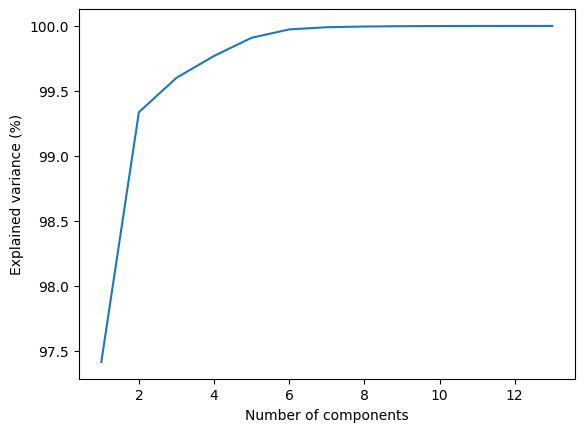

In [ ]:
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

#####Aplicando o PCA

In [ ]:
pca_components = abs(pca.components_)

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

print('\nThe most important features in each component')

top_values = 12 # get the indices of the top values in each row
for row in range(pca_components.shape[0]):
  temp = np.argpartition(-(pca_components[row]),top_values)
  # sort the indices in descending order
  indices = temp[np.argsort((-pca_components[row])[temp])][:top_values]

  # print the top feature names
  print(f'Component {row}: {df.columns[indices].to_list()}')


Cumulative Variances (Percentage):
[97.41242941 99.33569411 99.60044366]
Number of components: 3

The most important features in each component
Component 0: ['GT_C_airOut_pressure', 'HP_T_exit_pressure', 'GT_C_airOut_temp', 'GT_shaft_torque', 'P_prplr_torque', 'GT_rpm', 'GT_exhGas_pressure', 'HP_T_exit_temp', 'fuel_flow', 'lever_position', 'ship_speed', 'T_inj_control']
Component 1: ['GG_rpm', 'ship_speed', 'lever_position', 'T_inj_control', 'fuel_flow', 'GT_exhGas_pressure', 'P_prplr_torque', 'GT_shaft_torque', 'HP_T_exit_pressure', 'GT_C_airOut_temp', 'HP_T_exit_temp', 'GT_C_airOut_pressure']
Component 2: ['T_inj_control', 'GT_rpm', 'GT_exhGas_pressure', 'HP_T_exit_temp', 'HP_T_exit_pressure', 'GT_C_airOut_pressure', 'P_prplr_torque', 'GG_rpm', 'lever_position', 'GT_C_airOut_temp', 'ship_speed', 'fuel_flow']
Component 3: ['HP_T_exit_temp', 'T_inj_control', 'GT_C_airOut_temp', 'ship_speed', 'lever_position', 'GT_exhGas_pressure', 'fuel_flow', 'P_prplr_torque', 'GG_rpm', 'GT_shaft_torq

#####Modelagem

In [ ]:
# Splitando os dados em treino e teste
X_pca2_train, X_pca2_test, y1_pca2_train, y1_pca2_test = train_test_split(X_pca,y1)

In [ ]:
# Aplicando os modelos
y1_models_pca = train_models(X_pca2_train, y1_pca2_train, X_pca2_test, y1_pca2_test, models)
y1_models_pca.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                     5.755374            0.004919   
KNeighborsRegressor      0.00487            0.000979   
DecisionTreeRegressor   0.037248            0.001738   
BaggingRegressor        0.266941            0.001123   
XGBRegressor            0.797142            0.001562   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.005042            0.000056   
KNeighborsRegressor                         0.001004            0.000004   
DecisionTreeRegressor                       0.001784            0.000008   
BaggingRegressor                            0.001152            0.000004   
XGBRegressor                                0.001602            0.000006   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007483            0.735085   
KNeighborsRegressor                    0.00192            0.987775   
DecisionTreeRegressor                 0.002779                 1.0   
BaggingRegressor                      0.001975            0.996166   
XGBRegressor                          0.002411            0.992159   

                      Test Accuracy (R²)  
SVR                             0.746612  
KNeighborsRegressor             0.983311  
DecisionTreeRegressor           0.965039  
BaggingRegressor                0.982338  
XGBRegressor                    0.973686

Consideramos menos vantajoso, pois precisa de bastante features

#####Y2 - Aguardando Desenvolvimento

In [ ]:
y2_df_corr = df.corr()['GT_T_decay_coef'].abs().sort_values(ascending=False)
y2_df_corr

GT_T_decay_coef         1.000000e+00
HP_T_exit_temp          3.846390e-02
T_inj_control           1.887184e-02
GT_C_airOut_pressure    1.830336e-02
fuel_flow               1.732675e-02
GT_C_airOut_temp        1.685505e-02
GT_exhGas_pressure      1.179423e-02
GG_rpm                  1.000011e-02
HP_T_exit_pressure      2.718186e-03
GT_shaft_torque         3.576383e-04
S_prplr_torque          1.044235e-04
P_prplr_torque          1.044235e-04
GT_rpm                  1.776556e-05
GT_C_decay_coef         4.064242e-14
lever_position          8.566427e-17
ship_speed              9.367920e-18
Name: GT_T_decay_coef, dtype: float64

####PCA do Top VIF

In [ ]:
features = y1_calculated_vif[y1_calculated_vif['VIF'] < 1500].index.to_list()
print('Features (VIF < 1500):\n', features)

x1_pca_1500 = X.loc[:, features]

Features (VIF < 1500):
 ['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure']


In [ ]:
# Performing Standardization
sc_1500 = StandardScaler()
X_scaled_1500 = sc_1500.fit_transform(x1_pca_1500)

In [ ]:
components = 3
# None return the same number of original features in the dataset
# floating number between 0<n<1 return the number of components needed to capture the specified percentage of variability in the data
# an integer to indicate how many principal componentes you want to reduce the features to.

pca = PCA(n_components = components)

# Perform PCA on the scaled data
pca.fit(X_scaled_1500)

print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)

Variances (Percentage):
[95.07465453  4.29219066  0.6331548 ]


Text(0, 0.5, 'Explained variance (%)')

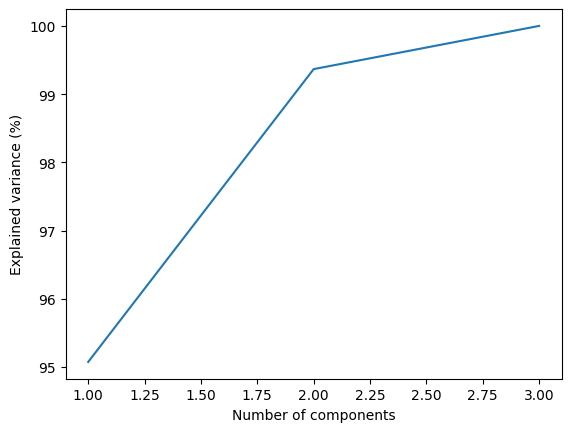

In [ ]:
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

#####Aplicando o PCA

In [ ]:
pca_components = abs(pca.components_)
print(pca_components)

[[0.57785504 0.56711934 0.58690647]
 [0.56416565 0.79721259 0.21487021]
 [0.58974628 0.20694863 0.78062257]]


In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled_1500)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

print('\nThe most important features in each component')

top_values = 2 # get the indices of the top values in each row
for row in range(pca_components.shape[0]):
  temp = np.argpartition(-(pca_components[row]),top_values)
  # sort the indices in descending order
  indices = temp[np.argsort((-pca_components[row])[temp])][:]

  # print the top 4 feature names
  print(f'Component {row}: {df.columns[indices].to_list()}')

Cumulative Variances (Percentage):
[ 95.07465453  99.3668452  100.        ]
Number of components: 3

The most important features in each component
Component 0: ['GT_shaft_torque', 'lever_position', 'ship_speed']
Component 1: ['ship_speed', 'lever_position', 'GT_shaft_torque']
Component 2: ['GT_shaft_torque', 'lever_position', 'ship_speed']


#####Modelagem

In [ ]:
#sc = StandardScaler()
#X_scaled = sc.fit_transform(x1_pca_1500)

#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X_scaled)

# Splitando os dados em traino e teste
X_pca2_train, X_pca2_test, y1_pca2_train, y1_pca2_test = train_test_split(X_pca,y1)

Redução de Dimensão e PCA

In [ ]:
# Aplicando os modelos
y1_PCA2_500_models = train_models(X_pca2_train, y1_pca2_train, X_pca2_test, y1_pca2_test, models)
y1_PCA2_500_models.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                     6.956795            0.005554   
KNeighborsRegressor     0.004925            0.001346   
DecisionTreeRegressor   0.036062            0.002121   
BaggingRegressor        0.280107            0.001587   
XGBRegressor            0.786644            0.002191   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.005697            0.000056   
KNeighborsRegressor                         0.001383             0.00001   
DecisionTreeRegressor                       0.002177             0.00002   
BaggingRegressor                             0.00163            0.000013   
XGBRegressor                                0.002251            0.000015   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                    0.00748            0.736916   
KNeighborsRegressor                   0.003137            0.969167   
DecisionTreeRegressor                 0.004416            0.999998   
BaggingRegressor                      0.003546            0.989038   
XGBRegressor                          0.003833            0.983804   

                      Test Accuracy (R²)  
SVR                             0.736574  
KNeighborsRegressor             0.953672  
DecisionTreeRegressor           0.908175  
BaggingRegressor                0.940791  
XGBRegressor                    0.930827

Redução de Dimensão sem PCA apenas para comparação

In [ ]:
y1_models_1500.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                      8.24336            0.005644   
KNeighborsRegressor     0.004911            0.001355   
DecisionTreeRegressor   0.029746            0.001834   
BaggingRegressor        0.217873            0.001253   
XGBRegressor            0.545556            0.001653   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.005791            0.000059   
KNeighborsRegressor                         0.001392             0.00001   
DecisionTreeRegressor                       0.001884            0.000015   
BaggingRegressor                            0.001287            0.000009   
XGBRegressor                                0.001698             0.00001   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007697             0.74197   
KNeighborsRegressor                   0.003236            0.970278   
DecisionTreeRegressor                 0.003904            0.999998   
BaggingRegressor                      0.003043             0.99384   
XGBRegressor                          0.003095            0.986712   

                      Test Accuracy (R²)  
SVR                             0.723537  
KNeighborsRegressor             0.951135  
DecisionTreeRegressor           0.928868  
BaggingRegressor                0.956803  
XGBRegressor                     0.95529

O resultado foi levemente menor.

Seguiremos com os modelos obtidos no y1_models_1500 <br>

## Visualização das Predições

In [ ]:
y1_pred_knn_reduced = y1_final_models['Y Predicted Test']['KNeighborsRegressor Otimizado']
y1_pred_bagg_reduced = y1_final_models['Y Predicted Test']['BaggingRegressor Otimizado']
y1_pred_svm_reduced = y1_final_models['Y Predicted Test']['SVR Otimizado']



In [ ]:
def Graph_prediction2d(x_train, y_train, x_test, y_test, y_pred):

  for i, x in enumerate(x_train):
    fig = go.Figure([
        go.Scatter(x=x_train.iloc[:,i], y=y_train, name='Train', mode='markers'),
        go.Scatter(x=x_test.iloc[:,i], y=y_test, name='Test', mode='markers'),
        go.Scatter(x=x_test.iloc[:,i], y=y_pred, name='Prediction', mode='markers')
    ])

    fig.update_layout(title=X.columns[i] +  ' x Target',

                        xaxis_title=X.columns[i],
                        yaxis_title='y',

                      width=600, height=500)
    fig.show()

In [ ]:
print('KNeighborsRegressor')
Graph_prediction2d(x_train_raw[x_columns_reduced], y1_train, x_test_raw[x_columns_reduced], y1_test, y1_pred_knn_reduced)

KNeighborsRegressor


In [ ]:
print('BaggingRegressor')
Graph_prediction2d(x_train_raw[x_columns_reduced], y1_train, x_test_raw[x_columns_reduced], y1_test, y1_pred_bagg_reduced)

BaggingRegressor


In [ ]:
print('SVR')
Graph_prediction2d(x_train_raw[x_columns_reduced], y1_train, x_test_raw[x_columns_reduced], y1_test, y1_pred_svm_reduced)

SVR


In [ ]:
def Graph_prediction3d(x, y_test, y_pred):
  x_ = x.iloc[:,0]
  z_ = x.iloc[:,1]
  y_ = x.iloc[:,2]

  # plotly data
  data=[go.Scatter3d(x=x_, y=y_, z=z_,mode='markers',
        marker=dict(
          size=7,
          color=y_test,
          #colorscale='Viridis',
          opacity=0.5,
          symbol='diamond')), # 'circle', 'circle-open', 'cross',
                      # 'diamond', 'diamond-open', 'square', 'square-open', 'x'

        go.Scatter3d(x=x_, y=y_, z=z_,mode='markers',
        marker=dict(
          size=5,
          color=y_pred,
          #colorscale='icefire',
          opacity=1,
          symbol='circle'))]

  fig = go.Figure(data)
  fig.update_layout(title='Main Features x Target',
                    scene=dict(
                    xaxis_title=X.columns[0],
                    yaxis_title=X.columns[1],
                    zaxis_title=X.columns[2]),
                    width=700, height=700)

  fig.show()

In [ ]:
print('KNeighborsRegressor')
Graph_prediction3d(x_test_raw[x_columns_reduced], y1_test, y1_pred_knn_reduced)

KNeighborsRegressor


In [ ]:
print('SVM')
Graph_prediction3d(x_test_raw[x_columns_reduced], y1_test, y1_pred_svm_reduced)

SVM


In [ ]:
fig = px.scatter_3d(x=x_test_raw[x_columns_reduced].iloc[:,0], y=x_test_raw[x_columns_reduced].iloc[:,2], z=x_test_raw[x_columns_reduced].iloc[:,1],  color=y1_test)
fig.show()

## Hiperparâmetros (Otimização Bayesiana)

###KNN

In [ ]:
def objective_knn(trial):
  """return the MAPE Score"""
  x_train = x_train_reduced
  y_train = y1_train

  param_obj_knn = {
      'n_neighbors': trial.suggest_int('n_neighbors', low=1, high=51, step=2),
      'leaf_size': trial.suggest_int('leaf_size', low=15, high=45, step=5),
      'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
      'metric': trial.suggest_categorical('metric', ['euclidean'])                  #, 'manhattan', 'minkowski'
  }
  knn = KNeighborsRegressor(**param_obj_knn)
  return cross_validation(x_train_reduced, y_train, knn)

In [ ]:
# create a study (aim to maximize score)
y1_study_knn = optuna.create_study(sampler=TPESampler(), direction='minimize')
y1_time_bayesian_knn = 0

[I 2023-06-10 01:17:55,006] A new study created in memory with name: no-name-bbf0ea89-449d-49e4-a9c3-bfda9bf5cd1e


In [ ]:
time_start = time.time()
y1_study_knn.optimize(objective_knn, n_trials=100)
y1_time_bayesian_knn += time.time() - time_start

[I 2023-06-08 16:42:31,948] Trial 0 finished with value: 0.0020960642689848976 and parameters: {'n_neighbors': 37, 'leaf_size': 45, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.0020960642689848976.
[I 2023-06-08 16:42:32,053] Trial 1 finished with value: 0.0017605872608119494 and parameters: {'n_neighbors': 21, 'leaf_size': 35, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.0017605872608119494.
[I 2023-06-08 16:42:32,156] Trial 2 finished with value: 0.0017605872608119494 and parameters: {'n_neighbors': 21, 'leaf_size': 25, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.0017605872608119494.
[I 2023-06-08 16:42:32,304] Trial 3 finished with value: 0.002847609648330712 and parameters: {'n_neighbors': 45, 'leaf_size': 15, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.0017605872608119494.
[I 2023-06-08 16:42:32,452] Trial 4 finished with value: 0.0023015463905074725 and

In [ ]:
# Salvando o estudo e o tempo
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
print(now)
with open(path_objects + 'y1_study_knn_' + now + '.pkl', 'wb') as f:
    pickle.dump(y1_study_knn, f)
    print(path_objects + 'y1_study_knn_' + now + '.pkl')

with open(path_objects + 'y1_time_bayesian_knn_' + now + '.pkl', 'wb') as f:
    pickle.dump(y1_time_bayesian_knn, f)
    print(path_objects + 'y1_time_bayesian_knn_' + now + '.pkl')

2023-06-08-12h56
/content/drive/MyDrive/ColabNotebooks/Objects/y1_study_knn_2023-06-08-12h56.pkl
/content/drive/MyDrive/ColabNotebooks/Objects/y1_time_bayesian_knn_2023-06-08-12h56.pkl


In [ ]:
# Abrindo o estudo e o tempo
model_finish_time = '2023-06-08-12h56'

file_study = 'y1_study_knn_' + model_finish_time + '.pkl'
with open(path_objects + file_study, 'rb') as f:
    y1_study_knn = pickle.load(f)

file_time = 'y1_time_bayesian_knn_' + model_finish_time + '.pkl'
with open(path_objects + file_time, 'rb') as f:
    y1_time_bayesian_knn = pickle.load(f)

In [ ]:
# Treinando o Modelo
y1_opt_knn_model = train_models(x_train_reduced, y1_train, x_test_reduced, y1_test, {'KNeighborsRegressor': KNeighborsRegressor(**y1_study_knn.best_trial.params)})

In [ ]:
# Métricas do Modelo
y1_opt_knn_model = metric_models(x_train_reduced, y1_train, x_test_reduced, y1_test, y1_opt_knn_model)
y1_opt_knn_model['Tempo [Estudo]'] = y1_time_bayesian_knn
y1_opt_knn_model['Melhor Tentativa'] = y1_study_knn.best_trial.number
y1_opt_knn_model.drop('Modelo',axis=1).drop('Y Predicted Test',axis=1)

Modelo                   MAPE       MAE      MSE      RMSE R² [Treino]  \
KNeighborsRegressor  0.001332  0.001296  0.00001  0.003172    0.999998   

Modelo              R² [Teste] Tempo [Treino] Tempo [Teste]  Tempo [Estudo]  \
KNeighborsRegressor   0.953039       0.026226      0.052624       13.279674   

Modelo               Melhor Tentativa  
KNeighborsRegressor                21

In [ ]:
# Salvando o Modelo
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
path_model = path_objects + 'y1_opt_knn_model_' + now + '.pkl'
with open(path_model, 'wb') as f:
    pickle.dump(y1_opt_knn_model, f)
print(path_model)

/content/drive/MyDrive/ColabNotebooks/Objects/y1_opt_knn_model_2023-06-08-13h45.pkl


###BaggingRegressor

In [ ]:
def objective_bagg(trial):
  """return the MAPE Score"""
  x_train = x_train_reduced
  y_train = y1_train
  x_test = x_test_reduced
  y_test = y1_test

  param_obj_bagg = {
      'n_estimators': trial.suggest_categorical('n_estimators', range(1,51,5)),
      'max_samples' : trial.suggest_categorical('max_samples', [0.6, 0.8, 1.0]),
      # 'max_features': trial.suggest_categorical('max_features', [0.6, 0.8, 1.0]),
      # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
      # 'bootstrap_features': trial.suggest_categorical('bootstrap_features', [True, False]),
      # 'warm_start': trial.suggest_categorical('warm_start', [True, False]),
                  }

  bagg = BaggingRegressor(**param_obj_bagg)

  # bagg.fit(x_train, y_train)
  # score = metrics.mean_absolute_percentage_error(y_test, bagg.predict(x_test))
  # return score

  return cross_validation(x_train, y_train, bagg) # Sem %

In [ ]:
# create a study (aim to maximize score)
y1_study_bagg = optuna.create_study(sampler=TPESampler(), direction='minimize') # maximize
y1_time_bayesian_bagg = 0

[I 2023-06-08 15:58:09,767] A new study created in memory with name: no-name-5c51a438-b59f-4e4b-90d1-09c77057c0f5


In [ ]:
time_start = time.time()
y1_study_bagg.optimize(objective_bagg, n_trials=100)
y1_time_bayesian_bagg += time.time() - time_start

[I 2023-06-08 15:58:12,094] Trial 0 finished with value: 0.0013035084819938178 and parameters: {'n_estimators': 21, 'max_samples': 0.6}. Best is trial 0 with value: 0.0013035084819938178.
[I 2023-06-08 15:58:17,469] Trial 1 finished with value: 0.0012397571624776697 and parameters: {'n_estimators': 41, 'max_samples': 0.8}. Best is trial 1 with value: 0.0012397571624776697.
[I 2023-06-08 15:58:20,318] Trial 2 finished with value: 0.0013361317391854248 and parameters: {'n_estimators': 11, 'max_samples': 0.8}. Best is trial 1 with value: 0.0012397571624776697.
[I 2023-06-08 15:58:21,953] Trial 3 finished with value: 0.001307467106668418 and parameters: {'n_estimators': 11, 'max_samples': 1.0}. Best is trial 1 with value: 0.0012397571624776697.
[I 2023-06-08 15:58:23,610] Trial 4 finished with value: 0.0012673275372804048 and parameters: {'n_estimators': 21, 'max_samples': 0.8}. Best is trial 1 with value: 0.0012397571624776697.
[I 2023-06-08 15:58:25,681] Trial 5 finished with value: 0.00

In [ ]:
# Salvando o estudo e o tempo
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
print(now)
with open(path_objects + 'y1_study_bagg_' + now + '.pkl', 'wb') as f:
    pickle.dump(y1_study_bagg, f)
    print(path_objects + 'y1_study_bagg_' + now + '.pkl')

with open(path_objects + 'y1_time_bayesian_bagg_' + now + '.pkl', 'wb') as f:
    pickle.dump(y1_time_bayesian_bagg, f)
    print(path_objects + 'y1_time_bayesian_bagg_' + now + '.pkl')

2023-06-08-13h03
/content/drive/MyDrive/ColabNotebooks/Objects/y1_study_bagg_2023-06-08-13h03.pkl
/content/drive/MyDrive/ColabNotebooks/Objects/y1_time_bayesian_bagg_2023-06-08-13h03.pkl


In [ ]:
# Abrindo o estudo e o tempo
model_finish_time = '2023-06-01-01-22'

file_study = 'y1_study_bagg_' + model_finish_time + '.pkl'
with open(path_objects + file_study, 'rb') as f:
    y1_study_bagg = pickle.load(f)

file_time = 'y1_time_bayesian_bagg_' + model_finish_time + '.pkl'
with open(path_objects + file_time, 'rb') as f:
    y1_time_bayesian_bagg = pickle.load(f)

In [ ]:
# Treinando o Modelo
y1_opt_bagg_model = train_models(x_train_reduced, y1_train, x_test_reduced, y1_test, {'BaggingRegressor': BaggingRegressor(**y1_study_bagg.best_trial.params)})

In [ ]:
# Métricas do Modelo
y1_opt_bagg_model = metric_models(x_train_reduced, y1_train, x_test_reduced, y1_test, y1_opt_bagg_model)
y1_opt_bagg_model['Tempo [Estudo]'] = y1_time_bayesian_bagg
y1_opt_bagg_model['Melhor Tentativa'] = y1_study_bagg.best_trial.number
y1_opt_bagg_model.drop('Modelo',axis=1).drop('Y Predicted Test',axis=1)

Modelo                MAPE       MAE       MSE      RMSE R² [Treino]  \
BaggingRegressor  0.001236  0.001203  0.000009  0.003062    0.994765   

Modelo           R² [Teste] Tempo [Treino] Tempo [Teste]  Tempo [Estudo]  \
BaggingRegressor   0.956265        2.03069      0.065058      341.267095   

Modelo            Melhor Tentativa  
BaggingRegressor                94

In [ ]:
# Salvando o Modelo
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
print (now)
path_model = path_objects + 'y1_opt_bagg_model_' + now + '.pkl'
with open(path_model, 'wb') as f:
    pickle.dump(y1_opt_bagg_model, f)
print(path_model)

2023-06-08-13h46
/content/drive/MyDrive/ColabNotebooks/Objects/y1_opt_bagg_model_2023-06-08-13h46.pkl


### SVM

In [ ]:
def objective_svm(trial):
  """return the MAPE Score"""
  x_train = x_train_reduced
  y_train = y1_train

  # Search Space
  param_obj_svm = {
    'kernel': trial.suggest_categorical('kernel', ['rbf']),

    'epsilon' : trial.suggest_float('epsilon', 1e-6, 1e+1, log=True),
    'gamma': trial.suggest_float('gamma', 1e-3, 1e+3, log=True),
    'C': trial.suggest_float('C', 1e-6, 1e+3, log=True),
                  }
  svm = SVR(**param_obj_svm)

  now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%Mm%Ss")
  with open(path_objects + 'y1_study_svm_' + now + f'{trial.number}.pkl', 'wb') as f:
    pickle.dump(y1_study_svm, f)

  with open(path_objects + 'y1_time_bayesian_svm_' + now + f'{trial.number}.pkl', 'wb') as f:
    pickle.dump(time.time() - time_start, f)


  return cross_validation(x_train, y_train, svm) # Sem %

In [ ]:
# create a study (aim to minimize score)
y1_study_svm = optuna.create_study(sampler=TPESampler(), direction='minimize')
y1_time_bayesian_svm = 0

[I 2023-06-01 18:58:35,817] A new study created in memory with name: no-name-b7d3e096-ff76-4e7a-82a2-207d2d128c56


In [ ]:
time_start = time.time()
y1_study_svm.optimize(objective_svm, n_trials=5)
y1_time_bayesian_svm += time.time() - time_start

[I 2023-06-12 10:55:42,712] Trial 95 finished with value: 0.0011025071063445954 and parameters: {'kernel': 'rbf', 'epsilon': 1.4997545369415636e-06, 'gamma': 92.84749226325236, 'C': 59.43979660414728}. Best is trial 61 with value: 0.0010903138736622366.
[I 2023-06-12 11:25:40,024] Trial 96 finished with value: 0.0010984502912531142 and parameters: {'kernel': 'rbf', 'epsilon': 3.1979221791903e-06, 'gamma': 39.14196419306027, 'C': 271.31311987712974}. Best is trial 61 with value: 0.0010903138736622366.
[I 2023-06-12 11:44:11,983] Trial 97 finished with value: 0.0010967792429785316 and parameters: {'kernel': 'rbf', 'epsilon': 1.3994669271557642e-06, 'gamma': 25.620776068068082, 'C': 190.81577771381154}. Best is trial 61 with value: 0.0010903138736622366.
[I 2023-06-12 12:02:06,710] Trial 98 finished with value: 0.0011095093580346647 and parameters: {'kernel': 'rbf', 'epsilon': 1.0225049503041127e-06, 'gamma': 25.73675834870975, 'C': 177.75031145027003}. Best is trial 61 with value: 0.0010

In [ ]:
# Salvando o estudo e o tempo
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
print(now)
with open(path_objects + 'y1_study_svm_' + now + '.pkl', 'wb') as f:
    pickle.dump(y1_study_svm, f)
    print(path_objects + 'y1_study_svm_' + now + '.pkl')

with open(path_objects + 'y1_time_bayesian_svm_' + now + '.pkl', 'wb') as f:
    pickle.dump(y1_time_bayesian_svm, f)
    print(path_objects + 'y1_time_bayesian_svm_' + now + '.pkl')

2023-06-12-09h19
/content/drive/MyDrive/ColabNotebooks/Objects/y1_study_svm_2023-06-12-09h19.pkl
/content/drive/MyDrive/ColabNotebooks/Objects/y1_time_bayesian_svm_2023-06-12-09h19.pkl


In [ ]:
# Abrindo o estudo e o tempo para continuar as tentativas
model_finish_time = '2023-06-12-09h19'

file_study = 'y1_study_svm_' + model_finish_time + '.pkl'
with open(path_objects + file_study, 'rb') as f:
    y1_study_svm = pickle.load(f)

file_time = 'y1_time_bayesian_svm_' + model_finish_time + '.pkl'
with open(path_objects + file_time, 'rb') as f:
    y1_time_bayesian_svm = pickle.load(f)

In [ ]:
# Treinando o Modelo
y1_opt_svm_model = train_models(x_train_reduced, y1_train, x_test_reduced, y1_test, {'SVR': SVR(**y1_study_svm.best_trial.params)})

In [ ]:
# Métricas do Modelo
y1_opt_svm_model = metric_models(x_train_reduced, y1_train, x_test_reduced, y1_test, y1_opt_svm_model)
y1_opt_svm_model['Tempo [Estudo]'] = y1_time_bayesian_svm
y1_opt_svm_model['Melhor Tentativa'] = y1_study_svm.best_trial.number
y1_opt_svm_model.drop('Modelo',axis=1).drop('Y Predicted Test',axis=1)

In [ ]:
y1_opt_svm_model_2 = train_models(x_train[['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']], y1_train, x_test[['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']], y1_test, {'SVR': SVR(**y1_study_svm.best_trial.params)})

In [ ]:
# Métricas do Modelo
y1_opt_svm_model_2 = metric_models(x_train_reduced, y1_train, x_test_reduced, y1_test, y1_opt_svm_model_2)
# y1_opt_svm_model_2['Tempo [Estudo]'] = y1_time_bayesian_svm
# y1_opt_svm_model_2['Melhor Tentativa'] = y1_study_svm.best_trial.number
y1_opt_svm_model_2.drop('Modelo',axis=1).drop('Y Predicted Test',axis=1)

In [ ]:
# Salvando o Modelo
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
print(now)
path_model = path_objects + 'y1_opt_svm_model_' + now + '.pkl'
with open(path_model, 'wb') as f:
    pickle.dump(y1_opt_svm_model, f)
print(path_model)

2023-06-12-09h36
/content/drive/MyDrive/ColabNotebooks/Objects/y1_opt_svm_model_2023-06-12-09h36.pkl


In [ ]:
# Treinando o Modelo com Dados Não-Normalizados
y1_opt_svm_model_raw = train_models(x_train_raw, y1_train, x_test_raw, y1_test, {'SVR': SVR(kernel='rbf', epsilon = 10E-4)})

In [ ]:
# Métricas do Modelo
y1_opt_svm_model_raw = metric_models(x_train_raw, y1_train, x_test_raw, y1_test, y1_opt_svm_model_raw)
#y1_opt_svm_model_raw['Tempo [Estudo]'] = y1_time_bayesian_svm
y1_opt_svm_model_raw['Melhor Tentativa'] = y1_study_svm.best_trial.number
y1_opt_svm_model_raw.drop('Modelo',axis=1).drop('Y Predicted Test',axis=1)

Modelo      MAPE       MAE       MSE      RMSE R² [Treino] R² [Teste]  \
SVR     0.012999  0.012667  0.000214  0.014641    0.999879  -0.000197   

Modelo Tempo [Treino] Tempo [Teste]  Melhor Tentativa  
SVR          8.875027      3.472452                61

In [ ]:
# Abrindo o Modelo SVM
path_model = 'model_y1.pkl'
with open(path_model, 'rb') as f:
    y1_opt_svm_model_raw_01 = pickle.load(f)

In [ ]:
# Métricas do Modelo
y1_opt_svm_model_raw_01 = metric_models(x_train_raw[['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']], y1_train, x_test_raw[['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']], y1_test, {'SVR': y1_opt_svm_model_raw_01})
#y1_opt_svm_model_raw['Tempo [Estudo]'] = y1_time_bayesian_svm
# y1_opt_svm_model_raw['Melhor Tentativa'] = y1_study_svm.best_trial.number
y1_opt_svm_model_raw_01.drop('Modelo',axis=1).drop('Y Predicted Test',axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


Modelo      MAPE      MAE       MSE      RMSE R² [Treino] R² [Teste]  \
SVR     0.000339  0.00033  0.000001  0.001079    0.996463   0.994566   

Modelo Tempo [Treino] Tempo [Teste]  
SVR               NaN      0.058234

In [ ]:
y1_opt_svm_model_raw_01

Modelo                                             Modelo      MAPE       MAE  \
SVR     SVR(C=516.7307055882856, epsilon=4.39688347817...  0.012999  0.012667   

Modelo       MSE      RMSE R² [Treino] R² [Teste] Tempo [Treino]  \
SVR     0.000214  0.014641    0.999879  -0.000197       8.875027   

Modelo Tempo [Teste]                                   Y Predicted Test  
SVR         5.600943  [0.9750497976976283, 0.9750497976976283, 0.975...

### Abrindo os Modelos e Estudos Salvos

#### Otimizados

In [ ]:
# Abrindo o Modelo KNN
path_model = '/content/drive/MyDrive/ColabNotebooks/Objects/y1_opt_knn_model_2023-06-08-13h45.pkl'
with open(path_model, 'rb') as f:
    y1_opt_knn_model = pickle.load(f)

# Abrindo o Modelo Bagg
path_model = '/content/drive/MyDrive/ColabNotebooks/Objects/y1_opt_bagg_model_2023-06-08-13h46.pkl'
with open(path_model, 'rb') as f:
    y1_opt_bagg_model = pickle.load(f)

# Abrindo o Modelo SVM
path_model = '/content/drive/MyDrive/ColabNotebooks/Objects/y1_opt_svm_model_2023-06-12-09h36.pkl'
with open(path_model, 'rb') as f:
    y1_opt_svm_model = pickle.load(f)


#### Estudos

In [ ]:
# Abrindo o estudo KNN
file_study = 'y1_study_knn_2023-06-08-12h56.pkl'
with open(path_objects + file_study, 'rb') as f:
    y1_study_knn = pickle.load(f)

# Abrindo o estudo Bagg
file_study = 'y1_study_bagg_2023-06-08-13h03.pkl'
with open(path_objects + file_study, 'rb') as f:
    y1_study_bagg = pickle.load(f)

# Abrindo o estudo SVM
file_study = 'y1_study_svm_2023-06-12-09h19.pkl'
with open(path_objects + file_study, 'rb') as f:
    y1_study_svm = pickle.load(f)

### Avaliando os Modelos

In [ ]:
y1_opt_models = pd.concat([y1_opt_knn_model, y1_opt_bagg_model, y1_opt_svm_model])

####KNN

In [ ]:
# Constroi um dataframe com os hiperparâmetros dos modelos
y1_knn_features = pd.DataFrame([y1_def_models['Modelo']['KNeighborsRegressor'].get_params(), y1_opt_models['Modelo']['KNeighborsRegressor'].get_params()],
                                index=['KNN Padrão', 'KNN Otimizado']).transpose()
y1_knn_features.columns.name = 'Features'
# Filtra para mostrar apenas os hiperparâmetros que usamos
y1_knn_features = y1_knn_features[y1_knn_features.index.isin(y1_study_knn.best_trial.params.keys())]

# # Adiciona o MAPE dos modelos
y1_knn_features.loc['MAPE'] = [y1_def_models['MAPE']['KNeighborsRegressor'],
                               y1_opt_models['MAPE']['KNeighborsRegressor']]

p2c(y1_knn_features)

Features                KNN Padrão         KNN Otimizado
leaf_size                       30                    45
metric                   minkowski             euclidean
n_neighbors                      5                     5
weights                    uniform              distance
MAPE         0,0013921445607169357  0,001331582673480695

In [ ]:
# optuna.visualization.plot_param_importances(y1_study_knn)

In [ ]:
# optuna.visualization.plot_parallel_coordinate(y1_study_knn, params=["n_neighbors", "leaf_size", "weights"])

####Bagg

In [ ]:
# Constroi um dataframe com os hiperparâmetros dos modelos
y1_bagg_features = pd.DataFrame([y1_def_models['Modelo']['BaggingRegressor'].get_params(), y1_opt_models['Modelo']['BaggingRegressor'].get_params()],
                                index=['Bagging Padrão', 'Bagging Otimizado']).transpose()
y1_bagg_features.columns.name = 'Features'
# Filtra para mostrar apenas os hiperparâmetros que usamos
y1_bagg_features = y1_bagg_features[y1_bagg_features.index.isin(y1_study_bagg.best_trial.params.keys())]

# # Adiciona o MAPE dos modelos
y1_bagg_features.loc['MAPE'] = [y1_def_models['MAPE']['BaggingRegressor'],
                               y1_opt_models['MAPE']['BaggingRegressor']]

p2c(y1_bagg_features)

Features             Bagging Padrão      Bagging Otimizado
max_samples                     1,0                    1,0
n_estimators                     10                     46
MAPE          0,0013323609814128148  0,0012355791290602105

In [ ]:
# optuna.visualization.plot_param_importances(y1_study_bagg)

In [ ]:
# optuna.visualization.plot_parallel_coordinate(y1_study_bagg)

####SVM

In [ ]:
# Constroi um dataframe com os hiperparâmetros dos modelos
y1_svm_features = pd.DataFrame([y1_def_models['Modelo']['SVR'].get_params(), y1_opt_models['Modelo']['SVR'].get_params()],
                                index=['SVR Padrão', 'SVR Otimizado']).transpose()
y1_svm_features.columns.name = 'Features'
# Filtra para mostrar apenas os hiperparâmetros que usamos
y1_svm_features = y1_svm_features[y1_svm_features.index.isin(y1_study_svm.best_trial.params.keys())]

# # Adiciona o MAPE dos modelos
y1_svm_features.loc['MAPE'] = [y1_def_models['MAPE']['SVR'],
                               y1_opt_models['MAPE']['SVR']]

p2c(y1_svm_features)

Features            SVR Padrão           SVR Otimizado
C                          1,0       516,7307055882856
epsilon                  0,001  4,3968834781751194e-05
gamma                    scale      28,937734726185486
kernel                     rbf                     rbf
MAPE      0,005793591135846666    0,001030005323721101

In [ ]:
# optuna.visualization.plot_param_importances(y1_study_svm)

In [ ]:
# optuna.visualization.plot_parallel_coordinate(y1_study_svm, params=["C", "epsilon", "gamma"])

## Conclusão

Modelos ordenados do melhor para o pior Test Accuracy (R²)

In [ ]:
y1_final_models = pd.concat([y1_def_models.rename(index=lambda x: f'{x} Padrão'), y1_opt_models.rename(index=lambda x: f'{x} Otimizado')]).sort_values('MAPE', ascending=True)
y1_final_models.drop('Modelo',axis=1).drop('Y Predicted Test',axis=1)

Modelo                             MAPE       MAE       MSE      RMSE  \
SVR Otimizado                   0.00103  0.001002  0.000009  0.003008   
BaggingRegressor Otimizado     0.001236  0.001203  0.000009  0.003062   
KNeighborsRegressor Otimizado  0.001332  0.001296   0.00001  0.003172   
BaggingRegressor Padrão        0.001332  0.001297   0.00001   0.00317   
KNeighborsRegressor Padrão     0.001392  0.001355   0.00001  0.003236   
SVR Padrão                     0.005794  0.005646  0.000059  0.007703   

Modelo                        R² [Treino] R² [Teste] Tempo [Treino]  \
SVR Otimizado                    0.959838   0.957774     871.663667   
BaggingRegressor Otimizado       0.994765   0.956265        2.03069   
KNeighborsRegressor Otimizado    0.999998   0.953039       0.008966   
BaggingRegressor Padrão          0.993752   0.953102       0.296573   
KNeighborsRegressor Padrão       0.970247   0.951135       0.008336   
SVR Padrão                       0.741611   0.723117       6.821074   

Modelo                        Tempo [Teste]  Tempo [Estudo]  Melhor Tentativa  
SVR Otimizado                      0.459873    34820.752451              61.0  
BaggingRegressor Otimizado         0.065058      341.267095              94.0  
KNeighborsRegressor Otimizado      0.018497       13.279674              21.0  
BaggingRegressor Padrão            0.008566             NaN               NaN  
KNeighborsRegressor Padrão         0.011776             NaN               NaN  
SVR Padrão                          1.05548             NaN               NaN

In [ ]:
# Y1 Final
y1_final_model = y1_final_models['Modelo']['SVR Otimizado']

In [ ]:
# Salvando os Modelos
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
path_model = path_objects + 'y1_final_models' + '_' + now + '.pkl'
with open(path_model, 'wb') as f:
    pickle.dump(y1_final_models, f)
print(path_model)

/content/drive/MyDrive/ColabNotebooks/Objects/y1_final_models_2023-06-12-09h41.pkl


In [ ]:
# Salvando o Modelo Final
now = (datetime.now() - timedelta(hours=3)).strftime("%Y-%m-%d-%Hh%M")
path_model = path_objects + 'y1_final_model' + '_' + now + '.pkl'
with open(path_model, 'wb') as f:
    pickle.dump(y1_final_model, f)
print(path_model)

/content/drive/MyDrive/ColabNotebooks/Objects/y1_final_model_2023-06-12-09h41.pkl


#MLOps

In [ ]:
with open(path_objects + 'scaler.pkl', 'wb') as files:
    pickle.dump(sc, files)

##Carregar o Modelo

### requirements

```
requirements.txt

# Function dependencies
# package>=version
scikit-learn==1.2.1
```



In [ ]:
import pickle

### Execução

In [ ]:
# # Gerando uma instância aleatória do dataset

# test_xy = x_test_raw[['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure']].join(y_test).sample()
# test_xy

In [ ]:
# Importando Período de Teste

In [ ]:
import pandas as pd

# Lendo o arquivo CSV e criando um dataframe
df1 = pd.read_csv('data_rows.csv')

# Exibindo os dataframes
df1

timestamp  lever_position  ship_speed  GT_shaft_torque  \
0    2023-06-13 22:12:01.853           2.088           6         3753.677   
1    2023-06-13 22:09:01.358           1.138           3         1159.522   
2    2023-06-13 22:06:01.892           9.300          27        72765.785   
3    2023-06-13 22:03:01.376           8.206          24        50993.925   
4    2023-06-13 22:00:02.117           7.148          21        38996.550   
..                       ...             ...         ...              ...   
995  2023-06-11 18:12:02.271           6.175          18        29761.035   
996  2023-06-11 18:09:01.646           5.140          15        21628.970   
997  2023-06-11 18:06:02.271           4.161          12        14720.613   
998  2023-06-11 18:03:01.643           3.144           9         8376.461   
999  2023-06-11 18:00:02.423           2.088           6         2822.060   

       GT_rpm    GG_rpm  S_prplr_torque  P_prplr_torque  HP_T_exit_temp  \
0    1386.949  6795.693          30.084          30.084         520.935   
1    1375.140  6657.207           8.925           8.925         472.290   
2    3560.396  9752.422         645.029         645.029        1076.592   
3    3087.485  9305.070         438.009         438.009         924.883   
4    2678.059  9122.724         332.371         332.371         827.509   
..        ...       ...             ...             ...             ...   
995  2306.782  8803.641         245.917         245.917         785.343   
996  1924.310  8473.534         175.237         175.237         716.656   
997  1547.452  7741.835         113.760         113.760         648.499   
998  1386.743  7062.387          60.314          60.314         593.273   
999  1360.752  6769.763          25.227          25.227         508.276   

     GT_C_airIn_temp  GT_C_airOut_temp  HP_T_exit_pressure  \
0                288           562.161               1.236   
1                288           548.973               1.134   
2                288           777.774               4.523   
3                288           731.525               3.590   
4                288           689.805               2.978   
..               ...               ...                 ...   
995              288           670.007               2.509   
996              288           639.272               2.085   
997              288           608.248               1.662   
998              288           582.019               1.391   
999              288           559.281               1.198   

     GT_C_airIn_pressure  GT_C_airOut_pressure  GT_exhGas_pressure  \
0                  0.998                 6.667               1.020   
1                  0.998                 6.105               1.019   
2                  0.998                22.775               1.050   
3                  0.998                18.559               1.042   
4                  0.998                15.634               1.036   
..                   ...                   ...                 ...   
995                0.998                13.369               1.030   
996                0.998                11.210               1.026   
997                0.998                 9.012               1.022   
998                0.998                 7.570               1.020   
999                0.998                 6.504               1.019   

     T_inj_control  fuel_flow  GT_C_decay_coef  GT_T_decay_coef  
0            0.000      0.149            0.978            0.984  
1            1.583      0.094            0.978            0.984  
2           89.509      1.772            0.978            0.983  
3           60.559      1.199            0.978            0.983  
4           44.227      0.876            0.978            0.983  
..             ...        ...              ...              ...  
995         34.971      0.692            0.974            0.977  
996         25.683      0.508            0.974            0.977  
997         1

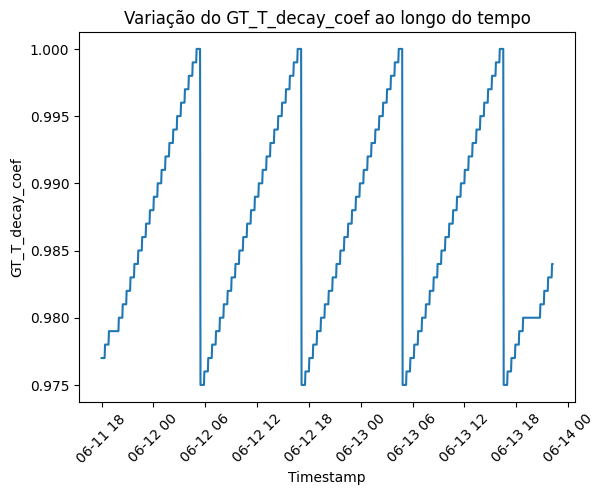

In [ ]:
import matplotlib.pyplot as plt

# Lendo o arquivo CSV e criando um dataframe
df = pd.read_csv('data_rows.csv')

# Convertendo a coluna 'timestamp' para o tipo de dados datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotando a coluna 'GT_T_decay_coef' em relação à coluna 'timestamp'
plt.plot(df['timestamp'], df['GT_T_decay_coef'])
plt.xlabel('Timestamp')
plt.ylabel('GT_T_decay_coef')
plt.title('Variação do GT_T_decay_coef ao longo do tempo')
plt.xticks(rotation=45)
plt.show()


In [ ]:
test_xy = df1[['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure', 'GT_C_decay_coef',	'GT_T_decay_coef']].sample()
test_xy

T_inj_control    GG_rpm  GT_exhGas_pressure  GT_C_decay_coef  \
46         23.475  6625.992               1.019            0.978   

    GT_T_decay_coef  
46            0.979

In [ ]:
test = test_xy[['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure']].values
test

array([[2.347500e+01, 6.625992e+03, 1.019000e+00]])

In [ ]:
# Y1

# load saved model
with open('y1_final_model_2023-06-09-20h14.pkl' , 'rb') as f: #path_objects +
    y1_model = pickle.load(f)

with open('sc_reduced_2023-06-08-19h10.pkl', 'rb') as f: # path_objects +
    sc = pickle.load(f)

test = sc.transform(test)
# check prediction
y1_model.predict(test)[0]

0.9775416946574945

In [ ]:
# Y2

# load saved model
with open('y2_final_model_2023-06-10-19h43.pkl' , 'rb') as f: #path_objects +
    y2_model = pickle.load(f)

with open('sc_reduced_2023-06-08-19h10.pkl', 'rb') as f: # path_objects +
    sc = pickle.load(f)

test = sc.transform(test)

# check prediction
y2_model.predict(test)[0]


0.9792639415970749

In [ ]:
test_xy1 = df1[['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure', 'GT_C_decay_coef']]
test_xy1.loc[:, 'predict'] = y1_model.predict(sc.transform(test_xy1.drop('GT_C_decay_coef', axis=1))).copy()
test_xy1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
<ipython-input-50-27e15a6d096c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_xy1.loc[:, 'predict'] = y1_model.predict(sc.transform(test_xy1.drop('GT_C_decay_coef', axis=1))).copy()


T_inj_control    GG_rpm  GT_exhGas_pressure  GT_C_decay_coef   predict
0            0.000  6795.693               1.020            0.978  0.982064
1            1.583  6657.207               1.019            0.978  0.986386
2           89.509  9752.422               1.050            0.978  0.977948
3           60.559  9305.070               1.042            0.978  0.977962
4           44.227  9122.724               1.036            0.978  0.978032
..             ...       ...                 ...              ...       ...
995         34.971  8803.641               1.030            0.974  0.974056
996         25.683  8473.534               1.026            0.974  0.973922
997         17.582  7741.835               1.022            0.974  0.974063
998         12.611  7062.387               1.020            0.974  0.974175
999         11.814  6769.763               1.019            0.974  0.971379

[1000 rows x 5 columns]

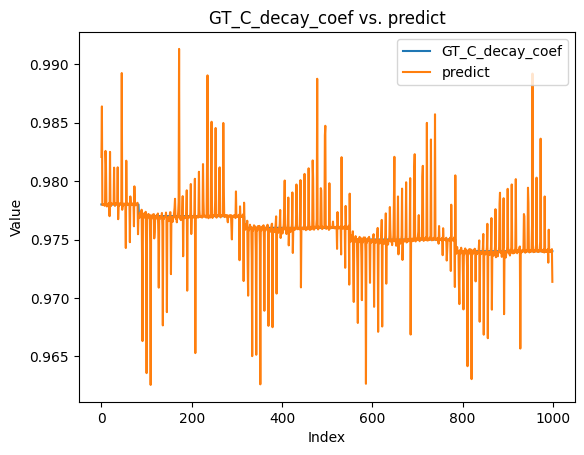

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Criar uma sequência de valores espaçados uniformemente
x = np.arange(len(test_xy1))

plt.plot(x, test_xy1['GT_C_decay_coef'], label='GT_C_decay_coef')
plt.plot(x, test_xy1['predict'], label='predict')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('GT_C_decay_coef vs. predict')
plt.legend()

plt.show()


In [ ]:
test_xy2 = df1[['T_inj_control', 'GG_rpm', 'GT_exhGas_pressure', 'GT_T_decay_coef']]
test_xy2.loc[:, 'predict'] = y2_model.predict(sc.transform(test_xy2.drop('GT_T_decay_coef', axis=1))).copy()
test_xy2

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
<ipython-input-48-5fb0c6009259>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_xy2.loc[:, 'predict'] = y2_model.predict(sc.transform(test_xy2.drop('GT_T_decay_coef', axis=1))).copy()


T_inj_control    GG_rpm  GT_exhGas_pressure  GT_T_decay_coef   predict
0            0.000  6795.693               1.020            0.984  0.986032
1            1.583  6657.207               1.019            0.984  0.989109
2           89.509  9752.422               1.050            0.983  0.982849
3           60.559  9305.070               1.042            0.983  0.982617
4           44.227  9122.724               1.036            0.983  0.982647
..             ...       ...                 ...              ...       ...
995         34.971  8803.641               1.030            0.977  0.977106
996         25.683  8473.534               1.026            0.977  0.976815
997         17.582  7741.835               1.022            0.977  0.977063
998         12.611  7062.387               1.020            0.977  0.976882
999         11.814  6769.763               1.019            0.977  0.976446

[1000 rows x 5 columns]

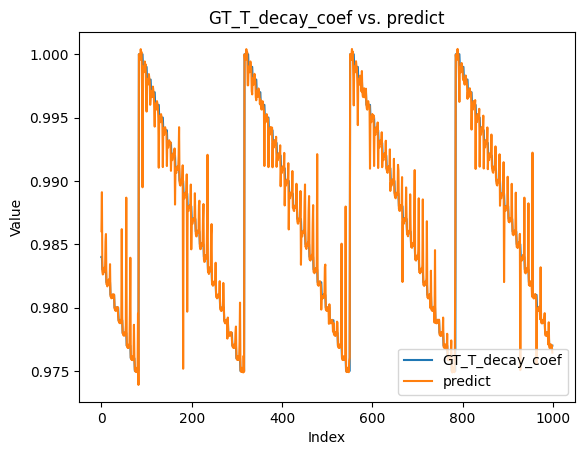

In [ ]:
# Criar uma sequência de valores espaçados uniformemente
x = np.arange(len(test_xy2))

plt.plot(x, test_xy2['GT_T_decay_coef'], label='GT_T_decay_coef')
plt.plot(x, test_xy2['predict'], label='predict')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('GT_T_decay_coef vs. predict')
plt.legend()

plt.show()
